In [1]:
# %load 2comp_sed.py
#!/usr/bin/env python

### 1D sedimentation simulation

Solve a one-dimensional polydisperse sedimentation problem


$\phi_t + (f(\phi))_x = 0 $

Here $\phi$ is a vector of volume fractions $\in[0,1]$. f is a user-specified function
for the flux of particles.  
The variable state.q is the same as $\phi$. It follows the notation from Leveque's book "Finite Volume Methods for Hyperbolic Problems" 2001.

In [2]:
from __future__ import absolute_import
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# boundary conditions
def lowerwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,i,...] = qbc[:,2*num_ghost-1-i,...]

def upperwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,-i-1,...] = qbc[:,-2*num_ghost+i,...]
        

def lowerdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.0])
    for i in range(num_ghost):
        qbc[:,i] = bvals

def upperdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.])
    for i in range(num_ghost):
        qbc[:,-i-1] = bvals

In [4]:
def qinit(state,x0,u_rel,IC='dam-break'):
    xc = state.grid.x.centers

In [5]:
def runsim(qinit=None,num_output_times=10,tfinal=1,mx=51,IC='dam-break',
    use_petsc=False,kernel_language='Python',outdir='./_output',solver_type='classic'):

    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Python':
        rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_fwave_1D
#         rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_1D
    elif kernel_language == 'Fortran':
        print('No fortran solver available for advection_nonlinear_1D')
        pass

    if solver_type == 'classic':
        solver = pyclaw.ClawSolver1D(rs)
        solver.limiters = pyclaw.limiters.tvd.vanleer
    elif solver_type == 'sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)

    solver.kernel_language = kernel_language
    solver.cfl_desired = 0.9
    print('solver cfl',solver.cfl_desired)
    solver.order = 2
    print('solver order',solver.order)

    solver.bc_lower[0] = pyclaw.BC.custom
    solver.bc_upper[0] = pyclaw.BC.custom
    
    solver.user_bc_lower = lowerdirichlet
    solver.user_bc_upper = upperdirichlet

    xlower = 0.0
    xupper = 1.0
    mx = mx  # from kwargs
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 2
    state = pyclaw.State(domain,num_eqn)

    # Gravitational constant
    state.problem_data['u_rel'] = np.array([1.,1/30.])
    state.problem_data['efix'] = False
    state.problem_data['basis'] = None

    xc = state.grid.x.centers
    print(xc)
    if IC=='uniform-all':
        c0 = np.array([0.25,0.])
        # state defaults to empty. Convert to ones and fill with c0
        state.q = np.ones_like(state.q)*c0[:,np.newaxis]

    elif IC=='dam-break':
        # I changed state.is_valid() to always return true for fortran contiguity
        x0 = 0.2
        cr0 = np.array([0.4,0.01])
        cl0 = np.array([0.3,0.05])
        state.q = np.ones_like(state.q)
        state.q = cl0[:,np.newaxis]*(xc <= x0)[np.newaxis,:] + \
                  cr0[:,np.newaxis]*(xc >  x0)[np.newaxis,:]

    elif IC=='perturbation':
        x1 = 0.3
        x2 = 0.7
        eps = 0.5
        scale = 0.25
        state.q[0,:] = scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x1)/eps)**2)
#         state.q[0,-1] = 1.0
        state.q[1,:] = 0*scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x2)/eps)**2)
    
    elif IC=='linear':
        c1 = 0.45
        c2 = 0
        dc1 = 0.01
        dc2 = 0.1
        state.q[0,:] = np.linspace(c1,c1+dc1,len(xc))
        state.q[1,:] = np.linspace(c2,c2+dc2,len(xc))
    
    claw = pyclaw.Controller()
    claw.keep_copy = True
    claw.num_output_times = num_output_times
    claw.tfinal = tfinal
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.outdir = outdir
    print(state.problem_data)
    
    return claw

How does Q_ave influence to the total net flux?  
How does mass get lost? Sum the fluxes at the interface and see if they equal zero
> interface flux sum $\ne$0  
> compact support for flux removes conservation from F-wave solver

In [14]:
# %%capture
np.set_printoptions(precision=5,linewidth=np.inf)
ntimes = 20
mx = 10
tfinal = 100
claw = runsim(num_output_times=ntimes,tfinal=tfinal,mx=mx,
              IC='uniform-all')
claw.run()

solver cfl 0.9
solver order 2
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
{'u_rel': array([1.     , 0.03333]), 'efix': False, 'basis': None}
ascii
2019-04-11 09:00:07,825 INFO CLAW: Solution 0 computed for time t=0.000000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.       0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.125    0.       0.10547 -0.       0.10547  0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.25     0.     

/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:91: RuntimeWarning: invalid value encountered in true_divide
  J  = (J1-J0)/dx


 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.28004e-59  0.00000e+00 -1.05601e-58  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.35211e-53  0.00000e+00 -1.07042e-52  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-2.12820e-48  0.00000e+00 -4.25618e-48  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-4.63924e-43  0.00000e+00 -9.27839e-43  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-5.22524e-35  0.00000e+00 -1.04505e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-1.52001e-20  0.00000e+00 -3.04001e-20  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.16171e-02  0.00000e+00  8.30581e-02 -0.00000e+00  8.30581e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.29864e-01  0.00000e+00 -6.95826e-02  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.05169e-102  0.00000e+000 -2.10338e-102  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07292e-096  0.00000e+000 -2.14583e-096  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.46653e-092  0.00000e+000 -8.93263e-092  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.33014e-087  0.00000e+000 -1.86601e-086  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.04060e-078  0.00000e+000 -2.08121e-078  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.22125e-045  0.00000e+000 -2.44251e-045  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33295e-002  0.00000e+000 -5.34998e-002  0.00000e+000 -5.34998e-002  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.44234e-117  0.00000e+000 -6.88467e-117  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.51552e-111  0.00000e+000 -7.03103e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.46996e-106  0.00000e+000 -2.93978e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.05704e-101  0.00000e+000 -6.11402e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.40594e-093  0.00000e+000 -6.81188e-093  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.03062e-055  0.00000e+000 -1.00612e-054  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.44559e-002  0.00000e+000 -1.14799e-001  0.00000e+000 -1.14799e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.35936e-122  0.00000e+000 -4.71871e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.41029e-116  0.00000e+000 -4.82058e-116  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00900e-111  0.00000e+000 -2.01791e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.09586e-106  0.00000e+000 -4.19168e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33439e-098  0.00000e+000 -4.66877e-098  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.58082e-058  0.00000e+000 -5.16163e-058  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.11784e-002  0.00000e+000 -1.37114e-001  0.00000e+000 -1.37114e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99745e-144  0.00000e+000 -3.99490e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04306e-138  0.00000e+000 -4.08611e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.58698e-134  0.00000e+000 -1.71731e-133  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77611e-128  0.00000e+000 -3.55219e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97623e-120  0.00000e+000 -3.95245e-120  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.55916e-072  0.00000e+000 -5.11832e-072  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.53647e-002  0.00000e+000 -2.29677e-001  0.00000e+000 -2.29677e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.51365e-156  0.00000e+000 -1.30273e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.66622e-150  0.00000e+000 -1.33324e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.80668e-145  0.00000e+000 -5.61309e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.79438e-140  0.00000e+000 -1.15886e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.44432e-132  0.00000e+000 -1.28886e-131  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.30779e-079  0.00000e+000 -2.61557e-079  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.54863e-002  0.00000e+000 -2.74515e-001  0.00000e+000 -2.74515e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.48881e-159  0.00000e+000 -2.97762e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.52395e-153  0.00000e+000 -3.04790e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.41965e-149  0.00000e+000 -1.28387e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.32458e-143  0.00000e+000 -2.64914e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.47296e-135  0.00000e+000 -2.94591e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.34345e-082  0.00000e+000 -1.26869e-081  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.84060e-002  0.00000e+000 -2.88160e-001  0.00000e+000 -2.88160e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32727e-164  0.00000e+000  2.65455e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.29349e-164  0.00000e+000  1.27789e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75588e-161  0.00000e+000 -3.51962e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.62330e-156  0.00000e+000 -7.24653e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.02734e-148  0.00000e+000 -8.05468e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.90094e-090  0.00000e+000 -1.18019e-089  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.75783e-002  0.00000e+000 -3.33164e-001  0.00000e+000 -3.33164e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.61430e-166  0.00000e+000  1.92286e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.75310e-165  0.00000e+000 -1.53519e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28990e-165  0.00000e+000  4.34379e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.62777e-164  0.00000e+000 -7.46225e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.45244e-157  0.00000e+000 -4.90489e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.73104e-096  0.00000e+000 -1.54621e-095  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.03511e-001  0.00000e+000 -3.64051e-001  0.00000e+000 -3.64051e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.63466e-166  0.00000e+000 -1.92693e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.25380e-165  0.00000e+000  1.34627e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.92017e-165  0.00000e+000  7.00168e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.04854e-166  0.00000e+000 -1.18323e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.34046e-165  0.00000e+000 -3.85831e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.97956e-104  0.00000e+000 -1.39591e-103  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.10715e-001  0.00000e+000 -4.03501e-001  0.00000e+000 -4.03501e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.02354e-167  0.00000e+000 -6.04707e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.38966e-167  0.00000e+000 -2.68517e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.41097e-166  0.00000e+000  4.56839e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.00285e-166  0.00000e+000  6.15365e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.30508e-166  0.00000e+000 -4.01090e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07631e-109  0.00000e+000 -2.15262e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.15365e-001  0.00000e+000 -4.30125e-001  0.00000e+000 -4.30125e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.29813e-001  0.00000e+000  4.31298e-001 -0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.09752e-170  0.00000e+000 -1.81950e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.30343e-169  0.00000e+000  2.22459e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.26173e-168  0.00000e+000  4.38191e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.37372e-168  0.00000e+000 -7.70910e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.16347e-168  0.00000e+000  1.29593e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.11124e-118  0.00000e+000 -2.22247e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.21791e-001  0.00000e+000 -4.68454e-001  0.00000e+000 -4.68454e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80192e-170  0.00000e+000 -3.60384e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02397e-171  0.00000e+000  7.61247e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.51754e-169  0.00000e+000  2.23335e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12751e-169  0.00000e+000 -3.01340e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.70171e-169  0.00000e+000 -2.64503e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.70601e-124  0.00000e+000 -3.41203e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.25526e-001  0.00000e+000 -4.91572e-001  0.00000e+000 -4.91572e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.68321e-171  0.00000e+000  7.36643e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33730e-170  0.00000e+000 -6.14788e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.21136e-170  0.00000e+000  2.39977e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.12378e-170  0.00000e+000  1.42705e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.35821e-169  0.00000e+000  4.64615e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.75623e-126  0.00000e+000 -5.51247e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.26617e-001  0.00000e+000 -4.98449e-001  0.00000e+000 -4.98449e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.10271e-172  0.00000e+000  1.42054e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.83743e-171  0.00000e+000  1.68338e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.09813e-170  0.00000e+000 -1.45460e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.40061e-170  0.00000e+000 -5.54288e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.57305e-170  0.00000e+000  3.19801e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.16537e-128  0.00000e+000 -2.33074e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.27969e-001  0.00000e+000 -5.07035e-001  0.00000e+000 -5.07035e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60070e-172  0.00000e+000  3.20141e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.78979e-172  0.00000e+000  1.31768e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.84851e-172  0.00000e+000 -2.10593e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.65212e-171  0.00000e+000 -4.36800e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.95668e-171  0.00000e+000  3.75888e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.39286e-133  0.00000e+000 -2.78571e-133  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.30753e-001  0.00000e+000 -5.24987e-001  0.00000e+000 -5.24987e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.14446e-173  0.00000e+000 -2.28891e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.92002e-174  0.00000e+000  2.99383e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.09757e-173  0.00000e+000  1.47853e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.96774e-173  0.00000e+000 -1.30450e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.31960e-173  0.00000e+000 -1.55297e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.80505e-140  0.00000e+000 -7.61010e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.34204e-001  0.00000e+000 -5.47737e-001  0.00000e+000 -5.47737e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.11794e-174  0.00000e+000  6.23588e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.29948e-173  0.00000e+000 -3.84613e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.86720e-173  0.00000e+000  7.10693e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.75147e-173  0.00000e+000  8.52663e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.83265e-173  0.00000e+000  3.63573e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.47266e-142  0.00000e+000 -1.49453e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35057e-001  0.00000e+000 -5.53444e-001  0.00000e+000 -5.53444e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.98756e-175  0.00000e+000  1.99751e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.17887e-174  0.00000e+000  1.03627e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.56068e-174  0.00000e+000 -1.35991e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80786e-173  0.00000e+000 -3.36795e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.26077e-173  0.00000e+000  2.46213e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.84938e-144  0.00000e+000 -1.36988e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.36052e-001  0.00000e+000 -5.60149e-001  0.00000e+000 -5.60149e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.17071e-175  0.00000e+000  4.34143e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.34184e-175  0.00000e+000  6.00083e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.28317e-175  0.00000e+000 -2.32509e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.34995e-174  0.00000e+000 -2.11819e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.43443e-174  0.00000e+000  3.94924e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.32624e-148  0.00000e+000 -2.65249e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.38265e-001  0.00000e+000 -5.75220e-001  0.00000e+000 -5.75220e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.85152e-177  0.00000e+000  7.70304e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.54498e-176  0.00000e+000  9.54936e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.06695e-176  0.00000e+000 -8.50542e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20231e-175  0.00000e+000 -2.76748e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84391e-175  0.00000e+000  1.48428e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.96876e-154  0.00000e+000 -5.93752e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.40765e-001  0.00000e+000 -5.92528e-001  0.00000e+000 -5.92528e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.74954e-177  0.00000e+000 -9.49907e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04216e-176  0.00000e+000 -2.18450e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02896e-176  0.00000e+000  8.32674e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.38234e-176  0.00000e+000  4.38003e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.79867e-176  0.00000e+000 -1.15474e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.13430e-156  0.00000e+000 -6.26860e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.41603e-001  0.00000e+000 -5.98397e-001  0.00000e+000 -5.98397e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.70622e-177  0.00000e+000  7.41244e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.93179e-178  0.00000e+000 -1.28385e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.13482e-176  0.00000e+000 -3.18442e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.46540e-176  0.00000e+000  4.52326e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.81830e-176  0.00000e+000  4.04414e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.17443e-158  0.00000e+000 -1.43489e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42284e-001  0.00000e+000 -6.03197e-001  0.00000e+000 -6.03197e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.47980e-178  0.00000e+000 -2.95959e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.07365e-177  0.00000e+000 -3.55539e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42624e-177  0.00000e+000  4.85023e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.14979e-177  0.00000e+000  8.30182e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.82345e-177  0.00000e+000 -6.95450e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.76303e-162  0.00000e+000 -1.75261e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.43863e-001  0.00000e+000 -6.14400e-001  0.00000e+000 -6.14400e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.49346e-166  0.00000e+000  1.29869e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.39674e-165  0.00000e+000 -7.39086e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.25256e-165  0.00000e+000  2.26894e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30932e-166  0.00000e+000 -3.29327e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93067e-164  0.00000e+000 -5.94253e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.09618e-165  0.00000e+000  5.07482e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45522e-001  0.00000e+000 -6.26300e-001  0.00000e+000 -6.26300e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.47530e-166  0.00000e+000  1.89506e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.64317e-165  0.00000e+000 -5.03787e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42292e-165  0.00000e+000 -5.62839e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.31459e-166  0.00000e+000  7.41131e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.67438e-165  0.00000e+000  3.00038e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.46145e-165  0.00000e+000 -7.42625e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.46480e-001  0.00000e+000 -6.33236e-001  0.00000e+000 -6.33236e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.99502e-167  0.00000e+000  7.99004e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32002e-166  0.00000e+000  1.04203e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.71121e-167  0.00000e+000 -5.42431e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.15411e-166  0.00000e+000 -3.14167e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.67541e-166  0.00000e+000  8.09907e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.71116e-166  0.00000e+000  6.67408e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.48533e-001  0.00000e+000 -6.48242e-001  0.00000e+000 -6.48242e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.02547e+00  0.00000e+00  4.71628e-17  0.00000e+00 -6.57031e-01  0.00000e+00  6.57031e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.08660e-168  0.00000e+000  1.21732e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.26830e-168  0.00000e+000 -4.28830e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.10427e-167  0.00000e+000 -6.06658e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.18416e-168  0.00000e+000  1.72383e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.43746e-166  0.00000e+000  1.25478e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.06124e-168  0.00000e+000 -6.12248e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.68877e-168  0.00000e+000  1.56225e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.09889e-167  0.00000e+000  2.29778e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25058e-168  0.00000e+000 -5.64545e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.10900e-167  0.00000e+000 -5.42266e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.04348e-167  0.00000e+000  7.55369e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.50660e-001  0.00000e+000 -6.64019e-001  0.00000e+000 -6.64019e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.64279e-169  0.00000e+000 -9.28557e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.43882e-169  0.00000e+000  9.69350e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.28024e-168  0.00000e+000  4.47890e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.64403e-168  0.00000e+000 -3.75133e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.02763e-168  0.00000e+000 -9.59199e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.36663e-168  0.00000e+000  4.91399e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.52356e-001  0.00000e+000 -6.76755e-001  0.00000e+000 -6.76755e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25662e-169  0.00000e+000  2.51324e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.88398e-169  0.00000e+000  7.41474e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.55152e-169  0.00000e+000 -1.76125e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.28742e-168  0.00000e+000  2.96713e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.63818e-169  0.00000e+000  3.20576e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.26037e-168  0.00000e+000  3.87350e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.53215e-001  0.00000e+000 -6.83265e-001  0.00000e+000 -6.83265e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.45249e-170  0.00000e+000 -1.29050e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.67450e-170  0.00000e+000  1.24610e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.13952e-169  0.00000e+000  6.36784e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.99368e-169  0.00000e+000 -4.65951e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.26287e-169  0.00000e+000 -1.38536e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.22119e-169  0.00000e+000  5.93695e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.53866e-001  0.00000e+000 -6.88223e-001  0.00000e+000 -6.88223e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.68636e-171  0.00000e+000 -1.13727e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.64221e-170  0.00000e+000  7.55897e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.05647e-170  0.00000e+000 -7.30461e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.71162e-170  0.00000e+000 -2.28057e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71917e-169  0.00000e+000 -1.54523e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.05720e-170  0.00000e+000  2.84236e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.55037e-001  0.00000e+000 -6.97196e-001  0.00000e+000 -6.97196e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.55192e-171  0.00000e+000  5.10384e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.97887e-171  0.00000e+000  1.75006e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.12400e-170  0.00000e+000 -3.61879e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.65165e-170  0.00000e+000  5.63501e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.28564e-171  0.00000e+000  6.59692e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.65386e-170  0.00000e+000  8.53661e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56078e-001  0.00000e+000 -7.05222e-001  0.00000e+000 -7.05222e-001  0.00000e+000  0.00000e+000 

[ 2.02366e+00  0.00000e+00  3.06965e-17  0.00000e+00 -7.11732e-01  0.00000e+00  7.11732e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.51586e-173  0.00000e+000 -1.50317e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.27698e-171  0.00000e+000 -4.25332e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.46757e-171  0.00000e+000  3.87214e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.30538e-171  0.00000e+000  1.36738e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.24208e-171  0.00000e+000 -9.80038e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.47853e-171  0.00000e+000 -1.36408e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.15630e-172  0.00000e+000 -2.31261e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.22255e-172  0.00000e+000 -3.81988e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.64668e-172  0.00000e+000  1.55583e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.49289e-171  0.00000e+000  1.10061e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.23562e-172  0.00000e+000 -3.43926e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95189e-171  0.00000e+000 -1.11164e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.58156e-001  0.00000e+000 -7.21429e-001  0.00000e+000 -7.21429e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.04559e-001  0.00000e+000  7.21813e-001 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71337e-173  0.00000e+000 -3.42673e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.99059e-173  0.00000e+000  2.48347e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.89653e-172  0.00000e+000 -4.88528e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01992e-172  0.00000e+000 -7.34438e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.49211e-172  0.00000e+000  4.00011e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.70935e-173  0.00000e+000  9.04233e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.59012e-001  0.00000e+000 -7.28164e-001  0.00000e+000 -7.28164e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.07058e-173  0.00000e+000  2.14116e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.95890e-174  0.00000e+000 -2.69054e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.51139e-173  0.00000e+000 -1.19240e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.25587e-173  0.00000e+000  1.24351e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03356e-172  0.00000e+000  2.07479e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.69385e-172  0.00000e+000 -7.54205e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.59841e-001  0.00000e+000 -7.34730e-001  0.00000e+000 -7.34730e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.79153e-174  0.00000e+000 -9.58307e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.46969e-174  0.00000e+000  1.42268e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.53453e-173  0.00000e+000  4.14032e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.16274e-173  0.00000e+000 -4.88389e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.68739e-173  0.00000e+000 -8.81637e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.10020e-173  0.00000e+000  5.99076e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.60429e-001  0.00000e+000 -7.39405e-001  0.00000e+000 -7.39405e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19875e-174  0.00000e+000  2.39750e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.17940e-174  0.00000e+000  1.56379e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.73976e-174  0.00000e+000 -1.74021e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.32016e-173  0.00000e+000  4.78497e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.52372e-174  0.00000e+000  3.09721e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.11182e-173  0.00000e+000  6.21683e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61147e-001  0.00000e+000 -7.45133e-001  0.00000e+000 -7.45133e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.51029e-175  0.00000e+000 -1.30206e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.85845e-175  0.00000e+000  4.37581e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.70197e-174  0.00000e+000  3.25643e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.12697e-175  0.00000e+000 -1.34858e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.08628e-173  0.00000e+000 -7.41444e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.48938e-174  0.00000e+000  1.61613e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61498e-001  0.00000e+000 -7.47951e-001  0.00000e+000 -7.47951e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.45561e-176  0.00000e+000 -8.91121e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.17165e-174  0.00000e+000 -2.16508e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.24433e-174  0.00000e+000  2.01972e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.18036e-174  0.00000e+000  6.82966e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.10626e-174  0.00000e+000 -4.97785e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.72169e-174  0.00000e+000 -6.67807e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61914e-001  0.00000e+000 -7.51292e-001  0.00000e+000 -7.51292e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.39043e-176  0.00000e+000 -8.78087e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.57182e-175  0.00000e+000  8.89981e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.03159e-175  0.00000e+000 -3.98026e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.57985e-175  0.00000e+000 -2.52426e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82853e-174  0.00000e+000  5.83169e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.13653e-177  0.00000e+000  3.08816e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.62526e-001  0.00000e+000 -7.56224e-001  0.00000e+000 -7.56224e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.99980e-176  0.00000e+000 -9.99961e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.17474e-175  0.00000e+000 -2.34957e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26143e-176  0.00000e+000  7.35134e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.30857e-175  0.00000e+000  6.61351e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.57665e-175  0.00000e+000 -1.60773e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.77201e-175  0.00000e+000 -6.61999e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.62926e-001  0.00000e+000 -7.59461e-001  0.00000e+000 -7.59461e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.01736e-001  0.00000e+000  7.59789e-001 -0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56495e-177  0.00000e+000 -3.12991e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.65576e-176  0.00000e+000  1.39375e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.22351e-176  0.00000e+000 -1.28020e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80713e-175  0.00000e+000 -3.77876e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.62604e-175  0.00000e+000  2.14095e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.12257e-176  0.00000e+000  4.73565e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.63580e-001  0.00000e+000 -7.64767e-001  0.00000e+000 -7.64767e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.01349e-001  0.00000e+000  7.65088e-001 -0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42825e-176  0.00000e+000 -2.85650e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.65001e-176  0.00000e+000  4.12970e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.27950e-176  0.00000e+000  1.54461e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.14897e-175  0.00000e+000 -3.02565e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.35190e-176  0.00000e+000 -3.26576e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03164e-175  0.00000e+000  4.72865e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.63901e-001  0.00000e+000 -7.67379e-001  0.00000e+000 -7.67379e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.01159e-001  0.00000e+000  7.67696e-001 -0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.57737e-177  0.00000e+000  1.11547e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.45207e-177  0.00000e+000 -3.12136e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.36502e-176  0.00000e+000 -4.71826e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.63425e-177  0.00000e+000  1.15214e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.48288e-176  0.00000e+000  7.37117e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.64176e-176  0.00000e+000 -9.05340e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.64281e-001  0.00000e+000 -7.70479e-001  0.00000e+000 -7.70479e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.00934e-001  0.00000e+000  7.70792e-001 -0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.51672e-177  0.00000e+000 -5.03343e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.86484e-177  0.00000e+000  4.33719e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.13242e-176  0.00000e+000  2.40410e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.53610e-176  0.00000e+000 -1.59674e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.78387e-176  0.00000e+000 -5.04319e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.30534e-176  0.00000e+000  2.00025e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.64902e-001  0.00000e+000 -7.75563e-001  0.00000e+000 -7.75563e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.21355e-178  0.00000e+000  1.44271e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.68915e-177  0.00000e+000 -6.26372e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.02644e-177  0.00000e+000 -4.41086e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61656e-177  0.00000e+000  2.16969e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.52261e-176  0.00000e+000  5.52224e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.76257e-177  0.00000e+000 -1.84493e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.65267e-001  0.00000e+000 -7.78565e-001  0.00000e+000 -7.78565e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.33535e-178  0.00000e+000 -8.67070e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.72374e-179  0.00000e+000  1.88862e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.51227e-177  0.00000e+000  2.98146e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00922e-177  0.00000e+000 -5.98756e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.08432e-177  0.00000e+000 -6.19952e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.55747e-177  0.00000e+000  7.25322e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.65833e-001  0.00000e+000 -7.83222e-001  0.00000e+000 -7.83222e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27695e-179  0.00000e+000  6.55390e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.69150e-178  0.00000e+000 -1.26938e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.60169e-178  0.00000e+000  4.87341e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30052e-177  0.00000e+000  4.03403e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.54511e-177  0.00000e+000 -1.54484e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.73726e-179  0.00000e+000 -3.70013e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.66185e-001  0.00000e+000 -7.86135e-001  0.00000e+000 -7.86135e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.86977e-179  0.00000e+000  1.37395e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.24458e-178  0.00000e+000  3.74125e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.21813e-178  0.00000e+000 -1.26667e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.12224e-177  0.00000e+000 -7.34193e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.96457e-178  0.00000e+000  2.18576e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30198e-177  0.00000e+000  1.21112e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.66533e-001  0.00000e+000 -7.89015e-001  0.00000e+000 -7.89015e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.43033e-179  0.00000e+000 -4.86066e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.30078e-178  0.00000e+000 -1.62942e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89828e-179  0.00000e+000  3.85132e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.08144e-178  0.00000e+000  4.69121e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.24938e-178  0.00000e+000 -8.35533e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.25183e-178  0.00000e+000 -4.64709e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.67046e-001  0.00000e+000 -7.93275e-001  0.00000e+000 -7.93275e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.64646e-179  0.00000e+000  3.29292e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.63367e-179  0.00000e+000  2.68150e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.04112e-179  0.00000e+000 -2.40311e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85178e-178  0.00000e+000 -9.22346e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.86357e-179  0.00000e+000  4.16852e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.77265e-178  0.00000e+000  1.00406e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.67438e-001  0.00000e+000 -7.96538e-001  0.00000e+000 -7.96538e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.69508e-180  0.00000e+000 -1.73902e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.69565e-179  0.00000e+000  8.67323e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.04766e-179  0.00000e+000  9.39989e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.10469e-179  0.00000e+000 -1.28582e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.36474e-179  0.00000e+000 -1.96530e-178  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20951e-178  0.00000e+000  2.19225e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.67878e-001  0.00000e+000 -8.00216e-001  0.00000e+000 -8.00216e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.49015e-180  0.00000e+000  6.98030e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.78979e-180  0.00000e+000 -1.95402e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.70995e-179  0.00000e+000 -2.90792e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.02601e-180  0.00000e+000  7.12262e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.19094e-179  0.00000e+000  4.46447e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.67341e-179  0.00000e+000 -5.49953e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.68204e-001  0.00000e+000 -8.02940e-001  0.00000e+000 -8.02940e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.51094e-180  0.00000e+000 -3.02187e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03432e-180  0.00000e+000  1.01124e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.06377e-179  0.00000e+000  7.09441e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.43271e-181  0.00000e+000 -3.02564e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.40347e-179  0.00000e+000 -1.59265e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42974e-179  0.00000e+000  3.54013e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.68631e-001  0.00000e+000 -8.06525e-001  0.00000e+000 -8.06525e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.92898e-181  0.00000e+000  1.18580e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.64724e-181  0.00000e+000 -1.84214e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.69806e-180  0.00000e+000 -6.08342e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.91455e-180  0.00000e+000  7.65044e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.92171e-180  0.00000e+000  1.00221e-179  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.52088e-180  0.00000e+000 -4.82375e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.69155e-001  0.00000e+000 -8.10935e-001  0.00000e+000 -8.10935e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.02049e+00  0.00000e+00  4.21755e-17  0.00000e+00 -8.13975e-01  0.00000e+00  8.13975e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.72055e-181  0.00000e+000 -5.44111e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.89664e-182  0.00000e+000  1.14615e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.56502e-180  0.00000e+000  1.92595e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.34857e-181  0.00000e+000 -3.58627e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.07890e-180  0.00000e+000 -4.04124e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.24875e-182  0.00000e+000  1.24975e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.27995e-181  0.00000e+000 -7.05939e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.09415e-181  0.00000e+000 -2.56900e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.37933e-181  0.00000e+000  2.35160e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59772e-180  0.00000e+000  1.67973e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.72102e-181  0.00000e+000 -2.01920e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.69921e-001  0.00000e+000 -8.17405e-001  0.00000e+000 -8.17405e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03344e-182  0.00000e+000  4.06688e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.99227e-181  0.00000e+000  3.17117e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.31295e-182  0.00000e+000 -5.89312e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.09898e-181  0.00000e+000 -7.56743e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.87442e-181  0.00000e+000  1.00166e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.19363e-181  0.00000e+000  1.01195e-180  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.70221e-001  0.00000e+000 -8.19946e-001  0.00000e+000 -8.19946e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.91957e-182  0.00000e+000 -5.83915e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.18107e-182  0.00000e+000 -4.68384e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.02580e-182  0.00000e+000  3.50976e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.98199e-181  0.00000e+000  1.04905e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.59052e-182  0.00000e+000 -7.33113e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.24922e-181  0.00000e+000 -8.49203e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.70566e-001  0.00000e+000 -8.22878e-001  0.00000e+000 -8.22878e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.10717e-183  0.00000e+000  8.21434e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.28270e-182  0.00000e+000  4.92252e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.75731e-183  0.00000e+000 -1.03365e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.02779e-181  0.00000e+000 -1.13709e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.17696e-182  0.00000e+000  1.75728e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.41710e-182  0.00000e+000  1.56153e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71050e-001  0.00000e+000 -8.27006e-001  0.00000e+000 -8.27006e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.13721e-183  0.00000e+000 -1.42744e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.90994e-183  0.00000e+000  2.07290e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.58157e-182  0.00000e+000  5.87222e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.13844e-182  0.00000e+000 -6.75848e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.29952e-182  0.00000e+000 -1.21174e-181  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.36763e-182  0.00000e+000  7.98124e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71289e-001  0.00000e+000 -8.29044e-001  0.00000e+000 -8.29044e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.96783e-001  0.00000e+000  8.29288e-001 -0.00000e+000  0.00000e+000  0.00000

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01999e+00  0.00000e+00 -2.75116e-17  0.00000e+00 -8.30662e-01  0.00000e+00  8.30662e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.21256e-185  0.00000e+000 -6.42512e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.06962e-182  0.00000e+000 -2.12639e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.39243e-182  0.00000e+000  1.48076e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.63820e-182  0.00000e+000  6.58050e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.05249e-182  0.00000e+000 -3.75191e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.09624e-183  0.00000e+000  4.19248e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25846e-183  0.00000e+000  1.31963e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.27735e-183  0.00000e+000 -2.72036e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88522e-182  0.00000e+000  8.05394e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.21471e-183  0.00000e+000  4.60798e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26117e-182  0.00000e+000  2.71417e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71759e-001  0.00000e+000 -8.33070e-001  0.00000e+000 -8.33070e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.39247e-184  0.00000e+000 -1.67849e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.37355e-183  0.00000e+000  8.10409e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.06982e-183  0.00000e+000  1.28844e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.84653e-183  0.00000e+000 -2.31211e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75013e-182  0.00000e+000 -4.18847e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.15167e-183  0.00000e+000  2.68878e-182  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71991e-001  0.00000e+000 -8.35058e-001  0.00000e+000 -8.35058e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.65194e-184  0.00000e+000  7.30389e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.92903e-184  0.00000e+000 -2.64658e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.12300e-183  0.00000e+000 -2.41362e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.39752e-184  0.00000e+000  9.13913e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.30473e-183  0.00000e+000  2.99082e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.81492e-183  0.00000e+000 -5.97044e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.72418e-001  0.00000e+000 -8.38727e-001  0.00000e+000 -8.38727e-001  0.00000e+000  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01970e+00  0.00000e+00  6.07153e-18  0.00000e+00 -8.40669e-01  0.00000e+00  8.40669e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.50753e-185  0.00000e+000  5.01507e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.16571e-184  0.00000e+000  1.53284e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.95864e-184  0.00000e+000 -1.97425e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.21864e-183  0.00000e+000 -3.65475e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.55612e-183  0.00000e+000  2.97978e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56273e-184  0.00000e+000 -3.12546e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.30867e-184  0.00000e+000 -3.66406e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.64977e-184  0.00000e+000  1.62833e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.29242e-183  0.00000e+000  2.65607e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.77258e-184  0.00000e+000 -3.36592e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01478e-183  0.00000e+000  9.08748e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.72956e-001  0.00000e+000 -8.43362e-001  0.00000e+000 -8.43362e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.61808e-185  0.00000e+000  1.32362e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.58754e-185  0.00000e+000 -1.92972e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.11574e-184  0.00000e+000 -7.01927e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.62407e-184  0.00000e+000  8.00263e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.17320e-184  0.00000e+000  1.15919e-183  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.66183e-184  0.00000e+000 -4.61466e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.73264e-001  0.00000e+000 -8.46024e-001  0.00000e+000 -8.46024e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.75217e-185  0.00000e+000 -5.50433e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.99755e-185  0.00000e+000  1.90038e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.94526e-184  0.00000e+000  1.19064e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.62793e-185  0.00000e+000 -5.60676e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.44284e-184  0.00000e+000 -2.75333e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.58773e-184  0.00000e+000  6.46354e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.73568e-001  0.00000e+000 -8.48658e-001  0.00000e+000 -8.48658e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01942e+00  0.00000e+00  5.99022e-18  0.00000e+00 -8.50150e-01  0.00000e+00  8.50150e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.26863e-185  0.00000e+000 -2.53726e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.13538e-185  0.00000e+000 -7.19624e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.43165e-186  0.00000e+000  1.89807e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.93045e-184  0.00000e+000  2.01147e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.01062e-185  0.00000e+000 -4.07026e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.11015e-184  0.00000e+000 -1.95217e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.10039e-186  0.00000e+000  6.20079e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.40065e-185  0.00000e+000  3.56114e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.55379e-186  0.00000e+000 -7.65168e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.48427e-185  0.00000e+000 -8.02763e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.04060e-185  0.00000e+000  1.29150e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.91878e-185  0.00000e+000  1.10038e-184  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.74164e-001  0.00000e+000 -8.53839e-001  0.00000e+000 -8.53839e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.63982e-187  0.00000e+000  1.52796e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.99583e-186  0.00000e+000 -1.50476e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.28003e-185  0.00000e+000  1.43865e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18099e-185  0.00000e+000  4.77817e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.10765e-185  0.00000e+000 -9.24841e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.47842e-186  0.00000e+000 -4.19478e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.74622e-001  0.00000e+000 -8.57832e-001  0.00000e+000 -8.57832e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.70616e-187  0.00000e+000  5.41232e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.79152e-186  0.00000e+000  6.50058e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.92831e-186  0.00000e+000 -1.02270e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.10224e-185  0.00000e+000 -1.56744e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.03932e-185  0.00000e+000  1.69327e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.07346e-186  0.00000e+000  2.00007e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.74909e-001  0.00000e+000 -8.60339e-001  0.00000e+000 -8.60339e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.52429e-187  0.00000e+000 -7.04859e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.70559e-186  0.00000e+000 -2.00146e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.38164e-188  0.00000e+000  5.22500e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.28718e-186  0.00000e+000  5.53699e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.54151e-186  0.00000e+000 -1.10283e-185  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.61444e-186  0.00000e+000 -5.28358e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75233e-001  0.00000e+000 -8.63171e-001  0.00000e+000 -8.63171e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.11382e-187  0.00000e+000  6.22764e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.13996e-188  0.00000e+000 -1.18273e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03549e-186  0.00000e+000 -2.95106e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.23776e-186  0.00000e+000  4.54652e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.36500e-186  0.00000e+000  4.65901e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.19117e-186  0.00000e+000 -3.00666e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75433e-001  0.00000e+000 -8.64924e-001  0.00000e+000 -8.64924e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.98431e-188  0.00000e+000 -1.19686e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.45451e-187  0.00000e+000  1.13027e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.61807e-187  0.00000e+000 -4.97561e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00496e-186  0.00000e+000 -3.03597e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.19088e-186  0.00000e+000  6.64123e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.75869e-188  0.00000e+000  3.56247e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75671e-001  0.00000e+000 -8.67011e-001  0.00000e+000 -8.67011e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.97807e-188  0.00000e+000 -1.59561e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.85316e-187  0.00000e+000 -2.51508e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05831e-187  0.00000e+000  1.03380e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.48259e-187  0.00000e+000  6.51054e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.01080e-187  0.00000e+000 -2.14541e-186  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.17625e-186  0.00000e+000 -6.09244e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75906e-001  0.00000e+000 -8.69079e-001  0.00000e+000 -8.69079e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21320e-188  0.00000e+000  1.04264e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.88464e-188  0.00000e+000 -1.50835e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.12810e-187  0.00000e+000 -5.32478e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.66323e-187  0.00000e+000  6.25452e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.74899e-187  0.00000e+000  8.56992e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.19434e-187  0.00000e+000 -3.67922e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.76139e-001  0.00000e+000 -8.71129e-001  0.00000e+000 -8.71129e-001  0.00000e+000  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01876e+00  0.00000e+00 -3.44573e-17  0.00000e+00 -8.72823e-01  0.00000e+00  8.72823e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.38174e-188  0.00000e+000 -2.76348e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.37933e-188  0.00000e+000  1.82856e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.38703e-187  0.00000e+000 -3.30372e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.28124e-187  0.00000e+000 -5.00616e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.67886e-187  0.00000e+000  2.10910e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.49427e-189  0.00000e+000  8.98854e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.51731e-188  0.00000e+000 -6.83232e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.20659e-188  0.00000e+000 -5.46245e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.44691e-188  0.00000e+000  2.18532e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.43918e-187  0.00000e+000 -1.96348e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.05622e-188  0.00000e+000 -1.87077e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.76711e-001  0.00000e+000 -8.76176e-001  0.00000e+000 -8.76176e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.19392e-189  0.00000e+000  6.38784e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.91451e-188  0.00000e+000  2.55144e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.33342e-189  0.00000e+000 -6.64714e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.13722e-188  0.00000e+000 -5.36062e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.28162e-188  0.00000e+000  1.10718e-187  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.13690e-188  0.00000e+000  7.76522e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.76935e-001  0.00000e+000 -8.78165e-001  0.00000e+000 -8.78165e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.19757e-189  0.00000e+000 -8.39515e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.92726e-190  0.00000e+000  1.60048e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.26207e-188  0.00000e+000  3.00221e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30830e-188  0.00000e+000 -4.90975e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.21402e-188  0.00000e+000 -6.13491e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.47520e-188  0.00000e+000  5.61255e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77121e-001  0.00000e+000 -8.79809e-001  0.00000e+000 -8.79809e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.34691e-190  0.00000e+000  1.86938e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.62350e-189  0.00000e+000 -1.09858e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07955e-188  0.00000e+000 -3.35819e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.32883e-189  0.00000e+000  3.56068e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.38073e-188  0.00000e+000  1.35001e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.61915e-189  0.00000e+000 -2.97262e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77378e-001  0.00000e+000 -8.82092e-001  0.00000e+000 -8.82092e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.65776e-191  0.00000e+000  7.31552e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.78873e-189  0.00000e+000  5.43115e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.37655e-189  0.00000e+000 -6.25551e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.52486e-189  0.00000e+000 -1.35473e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.29560e-189  0.00000e+000  1.00058e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.99161e-189  0.00000e+000  1.65686e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77633e-001  0.00000e+000 -8.84352e-001  0.00000e+000 -8.84352e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.33716e-190  0.00000e+000 -1.46743e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.81829e-190  0.00000e+000  1.77120e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.31417e-189  0.00000e+000  6.02080e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.43059e-189  0.00000e+000 -5.78797e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.45604e-189  0.00000e+000 -1.19853e-188  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.04364e-189  0.00000e+000  6.81007e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77792e-001  0.00000e+000 -8.85773e-001  0.00000e+000 -8.85773e-001  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.17843e-190  0.00000e+000  4.35686e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.84923e-190  0.00000e+000 -1.64122e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91643e-189  0.00000e+000 -1.42181e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.10049e-190  0.00000e+000  5.47477e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.74541e-189  0.00000e+000  1.79596e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.50623e-189  0.00000e+000 -4.27433e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.78042e-001  0.00000e+000 -8.87998e-001  0.00000e+000 -8.87998e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.92781e-001  0.00000e+000  8.88185e-001 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.82807e-191  0.00000e+000  5.65613e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.17068e-190  0.00000e+000  9.21013e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.18626e-190  0.00000e+000 -1.31790e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45001e-189  0.00000e+000 -2.21938e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.50260e-189  0.00000e+000  2.11420e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.32434e-190  0.00000e+000  2.75586e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.78254e-001  0.00000e+000 -8.89888e-001  0.00000e+000 -8.89888e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.86475e-191  0.00000e+000 -1.57295e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33497e-190  0.00000e+000 -1.52404e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59105e-190  0.00000e+000  9.37608e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.08095e-190  0.00000e+000  3.60373e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.51868e-191  0.00000e+000 -1.90619e-189  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07577e-189  0.00000e+000 -3.15726e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.78498e-001  0.00000e+000 -8.92073e-001  0.00000e+000 -8.92073e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.86209e-191  0.00000e+000  7.72417e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.32676e-191  0.00000e+000 -2.61019e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.21713e-190  0.00000e+000 -2.75871e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.50051e-191  0.00000e+000  8.89286e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.20524e-190  0.00000e+000  3.81773e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.71238e-190  0.00000e+000 -6.80347e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.78671e-001  0.00000e+000 -8.93622e-001  0.00000e+000 -8.93622e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.41700e-192  0.00000e+000 -1.48340e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.59383e-191  0.00000e+000  1.61545e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.04113e-190  0.00000e+000 -8.51958e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.51692e-190  0.00000e+000 -4.26414e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.05950e-190  0.00000e+000  1.17898e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.24583e-192  0.00000e+000  4.98494e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.78911e-001  0.00000e+000 -8.95772e-001  0.00000e+000 -8.95772e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.25238e-191  0.00000e+000 -2.50475e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.03620e-191  0.00000e+000 -3.06290e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14687e-191  0.00000e+000  1.54290e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.36408e-190  0.00000e+000  7.55887e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61379e-191  0.00000e+000 -3.16129e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75616e-190  0.00000e+000 -6.73780e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79115e-001  0.00000e+000 -8.97599e-001  0.00000e+000 -8.97599e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.90210e-192  0.00000e+000  1.18042e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.39754e-191  0.00000e+000  4.34239e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33588e-191  0.00000e+000 -7.90108e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.68774e-191  0.00000e+000  1.19736e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.41932e-191  0.00000e+000  1.30168e-190  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.83928e-191  0.00000e+000  1.82317e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79384e-001  0.00000e+000 -9.00012e-001  0.00000e+000 -9.00012e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.41302e-192  0.00000e+000 -6.82604e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.20155e-192  0.00000e+000  5.24898e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.39627e-191  0.00000e+000  3.10796e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02910e-191  0.00000e+000 -1.84232e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00665e-191  0.00000e+000 -6.22917e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.00889e-191  0.00000e+000  2.22470e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79649e-001  0.00000e+000 -9.02400e-001  0.00000e+000 -9.02400e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.92216e-193  0.00000e+000  1.78443e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.82294e-192  0.00000e+000 -9.21473e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.45382e-192  0.00000e+000 -4.04704e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.49745e-192  0.00000e+000  2.99496e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.01119e-191  0.00000e+000  3.27924e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.53631e-192  0.00000e+000 -2.44303e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79846e-001  0.00000e+000 -9.04174e-001  0.00000e+000 -9.04174e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.91711e-001  0.00000e+000  9.04348e-001 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.75213e-193  0.00000e+000  1.35043e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.81430e-192  0.00000e+000  2.92774e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.44091e-192  0.00000e+000 -1.14381e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.62576e-192  0.00000e+000 -4.93156e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.66049e-192  0.00000e+000  1.88621e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12273e-191  0.00000e+000  8.91353e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80009e-001  0.00000e+000 -9.05642e-001  0.00000e+000 -9.05642e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.99582e-193  0.00000e+000 -1.19916e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.65292e-193  0.00000e+000  3.12891e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.63287e-192  0.00000e+000  3.40625e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.65737e-193  0.00000e+000 -9.14051e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.36144e-192  0.00000e+000 -7.11384e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.77135e-192  0.00000e+000  1.02940e-191  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80170e-001  0.00000e+000 -9.07101e-001  0.00000e+000 -9.07101e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.08645e-194  0.00000e+000  1.41729e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.62511e-193  0.00000e+000 -1.80848e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.46016e-192  0.00000e+000  4.13185e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.54743e-192  0.00000e+000  5.60199e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.58583e-192  0.00000e+000 -1.52519e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.95708e-193  0.00000e+000 -4.85505e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80394e-001  0.00000e+000 -9.09128e-001  0.00000e+000 -9.09128e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01770e+00  0.00000e+00 -2.59124e-17  0.00000e+00 -9.10564e-01  0.00000e+00  9.10564e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.13282e-193  0.00000e+000  2.26564e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.86610e-193  0.00000e+000  5.20091e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.26514e-193  0.00000e+000 -1.94634e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.65005e-192  0.00000e+000 -9.00732e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.98512e-193  0.00000e+000  3.20381e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00058e-193  0.00000e+000 -2.00116e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.33745e-193  0.00000e+000  1.32740e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.95432e-193  0.00000e+000  9.25615e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.19191e-193  0.00000e+000 -4.78098e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.44469e-193  0.00000e+000 -1.84922e-192  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.17761e-192  0.00000e+000  5.82938e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80804e-001  0.00000e+000 -9.12843e-001  0.00000e+000 -9.12843e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.63746e-194  0.00000e+000  7.27492e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.79028e-194  0.00000e+000 -2.01304e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.73495e-193  0.00000e+000 -2.89880e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.65125e-194  0.00000e+000  7.03845e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.95284e-193  0.00000e+000  4.19749e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.49430e-193  0.00000e+000 -5.11458e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.81022e-001  0.00000e+000 -9.14819e-001  0.00000e+000 -9.14819e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.17874e-195  0.00000e+000  1.83575e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.19987e-194  0.00000e+000  1.27283e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.20839e-194  0.00000e+000 -2.47112e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.44601e-193  0.00000e+000 -2.86258e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86705e-193  0.00000e+000  4.02051e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02758e-193  0.00000e+000  3.76875e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.81176e-001  0.00000e+000 -9.16219e-001  0.00000e+000 -9.16219e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01749e+00  0.00000e+00 -3.90042e-17  0.00000e+00 -9.17888e-01  0.00000e+00  9.17888e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42764e-194  0.00000e+000 -2.85528e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.24149e-194  0.00000e+000 -7.72416e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.05314e-194  0.00000e+000  1.53617e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20806e-193  0.00000e+000  6.93166e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.98720e-194  0.00000e+000 -3.08287e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01745e+00  0.00000e+00 -4.40999e-17  0.00000e+00 -9.19545e-01  0.00000e+00  9.19545e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.29986e-195  0.00000e+000  1.25997e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.02305e-195  0.00000e+000 -3.52455e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.75499e-194  0.00000e+000 -4.98081e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.10565e-194  0.00000e+000  1.22795e-193  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.61923e-194  0.00000e+000  7.17029e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.13190e-195  0.00000e+000 -6.26379e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.88469e-195  0.00000e+000  1.62970e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.88604e-194  0.00000e+000  1.76545e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.02216e-195  0.00000e+000 -4.73309e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.80060e-194  0.00000e+000 -3.67253e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.98442e-194  0.00000e+000  5.30489e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.81841e-001  0.00000e+000 -9.22279e-001  0.00000e+000 -9.22279e-001  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.98438e-196  0.00000e+000 -5.96875e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.37789e-195  0.00000e+000 -9.56203e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.30663e-195  0.00000e+000  9.70455e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.35848e-194  0.00000e+000  2.80783e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.65764e-194  0.00000e+000 -2.20951e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.00634e-195  0.00000e+000 -2.50703e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82019e-001  0.00000e+000 -9.23898e-001  0.00000e+000 -9.23898e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.09022e-196  0.00000e+000  1.81804e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.21560e-195  0.00000e+000  7.95108e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.48351e-195  0.00000e+000 -1.21933e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.81429e-195  0.00000e+000  1.53177e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.84117e-195  0.00000e+000  1.97792e-194  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32852e-194  0.00000e+000  3.10891e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82195e-001  0.00000e+000 -9.25511e-001  0.00000e+000 -9.25511e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.54970e-196  0.00000e+000 -9.09940e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.53722e-196  0.00000e+000 -8.75640e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37046e-195  0.00000e+000  4.73593e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.63317e-195  0.00000e+000 -2.10520e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.19679e-195  0.00000e+000 -9.44939e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.62436e-195  0.00000e+000  5.94241e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82457e-001  0.00000e+000 -9.27907e-001  0.00000e+000 -9.27907e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.85570e-196  0.00000e+000  3.71141e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04318e-196  0.00000e+000 -1.15092e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.47079e-195  0.00000e+000 -1.38202e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97553e-196  0.00000e+000  3.92849e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.72678e-195  0.00000e+000  1.92017e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.23445e-195  0.00000e+000 -2.90484e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82629e-001  0.00000e+000 -9.29491e-001  0.00000e+000 -9.29491e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.28687e-198  0.00000e+000  1.85737e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.92753e-196  0.00000e+000  7.48359e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.09511e-196  0.00000e+000 -9.14845e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.05628e-195  0.00000e+000 -1.81673e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.24587e-195  0.00000e+000  1.43755e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.75967e-196  0.00000e+000  2.20613e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82801e-001  0.00000e+000 -9.31063e-001  0.00000e+000 -9.31063e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.19398e-197  0.00000e+000 -1.63880e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61258e-196  0.00000e+000  5.24321e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.59936e-196  0.00000e+000  8.37144e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.29171e-196  0.00000e+000 -9.86742e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.54422e-196  0.00000e+000 -1.66851e-195  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00379e-195  0.00000e+000  1.69784e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82970e-001  0.00000e+000 -9.32624e-001  0.00000e+000 -9.32624e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.16030e-197  0.00000e+000  6.32059e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.24547e-197  0.00000e+000 -2.11321e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.59710e-196  0.00000e+000 -2.23190e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45231e-197  0.00000e+000  7.13564e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.91710e-196  0.00000e+000  2.98903e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.73229e-196  0.00000e+000 -5.35865e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.83139e-001  0.00000e+000 -9.34174e-001  0.00000e+000 -9.34174e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01701e+00  0.00000e+00  5.54298e-17  0.00000e+00 -9.35458e-01  0.00000e+00  9.35458e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.02593e-198  0.00000e+000  6.05187e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.08667e-197  0.00000e+000  1.29630e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.78854e-197  0.00000e+000 -1.75592e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94493e-196  0.00000e+000 -3.09164e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.10065e-196  0.00000e+000  2.78021e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.41637e-198  0.00000e+000 -1.48327e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.41027e-197  0.00000e+000 -3.85400e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.02748e-198  0.00000e+000  1.04690e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03149e-196  0.00000e+000  1.03663e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.73065e-197  0.00000e+000 -2.15349e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.08255e-196  0.00000e+000 -9.57744e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.83527e-001  0.00000e+000 -9.37749e-001  0.00000e+000 -9.37749e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.47205e-198  0.00000e+000  1.09441e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.04092e-197  0.00000e+000 -1.06986e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.39398e-197  0.00000e+000 -6.76281e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.55942e-197  0.00000e+000  2.43193e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.10110e-197  0.00000e+000  1.08891e-196  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.70379e-197  0.00000e+000  3.16276e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.83718e-001  0.00000e+000 -9.39515e-001  0.00000e+000 -9.39515e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.87312e-198  0.00000e+000 -3.74625e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.33709e-198  0.00000e+000  2.21667e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72352e-197  0.00000e+000 -2.37047e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35863e-197  0.00000e+000 -5.92726e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.35581e-197  0.00000e+000 -6.71036e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.04760e-197  0.00000e+000  6.68352e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.83854e-001  0.00000e+000 -9.40767e-001  0.00000e+000 -9.40767e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.17394e-198  0.00000e+000 -4.34787e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.65831e-198  0.00000e+000 -2.62088e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.17727e-198  0.00000e+000  2.42921e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.99146e-197  0.00000e+000  5.18256e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75142e-198  0.00000e+000 -4.85146e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.77542e-197  0.00000e+000 -3.49089e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.83988e-001  0.00000e+000 -9.42012e-001  0.00000e+000 -9.42012e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11828e-198  0.00000e+000  2.23655e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.41803e-199  0.00000e+000 -2.98949e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.42332e-198  0.00000e+000 -1.13408e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.89043e-198  0.00000e+000  1.24066e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.16976e-198  0.00000e+000  1.77138e-197  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.46656e-197  0.00000e+000 -6.72212e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84175e-001  0.00000e+000 -9.43744e-001  0.00000e+000 -9.43744e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.13247e-199  0.00000e+000 -8.26493e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.59889e-199  0.00000e+000 -2.66791e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12283e-198  0.00000e+000  4.43222e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.50392e-198  0.00000e+000  3.29969e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.37777e-199  0.00000e+000 -8.81337e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.14250e-198  0.00000e+000  3.93195e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84466e-001  0.00000e+000 -9.46437e-001  0.00000e+000 -9.46437e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05709e-199  0.00000e+000  2.11419e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.30297e-199  0.00000e+000  4.37757e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.28213e-199  0.00000e+000 -1.75478e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45850e-198  0.00000e+000 -7.05792e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.89942e-199  0.00000e+000  2.84290e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.68224e-198  0.00000e+000  1.30147e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84726e-001  0.00000e+000 -9.48856e-001  0.00000e+000 -9.48856e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.29295e-200  0.00000e+000 -1.85859e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.06702e-199  0.00000e+000  1.58313e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80386e-199  0.00000e+000  8.15864e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.22857e-199  0.00000e+000 -5.30921e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.48304e-199  0.00000e+000 -1.61140e-198  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.04217e-198  0.00000e+000  6.23671e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84907e-001  0.00000e+000 -9.50534e-001  0.00000e+000 -9.50534e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.51451e-200  0.00000e+000  7.02903e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.24153e-201  0.00000e+000 -1.36097e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.26482e-199  0.00000e+000 -3.21349e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.33825e-199  0.00000e+000  5.06664e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.62391e-199  0.00000e+000  4.85767e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.43787e-199  0.00000e+000 -3.22975e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85111e-001  0.00000e+000 -9.52435e-001  0.00000e+000 -9.52435e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.94698e-201  0.00000e+000 -9.89396e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.58043e-200  0.00000e+000  1.31397e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.92744e-200  0.00000e+000 -8.44565e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.30017e-199  0.00000e+000 -3.34125e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.37171e-199  0.00000e+000  1.19817e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.54059e-200  0.00000e+000  3.85336e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85263e-001  0.00000e+000 -9.53850e-001  0.00000e+000 -9.53850e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.74276e-201  0.00000e+000 -1.54855e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.36947e-200  0.00000e+000 -3.64183e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.08294e-201  0.00000e+000  1.05974e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02366e-199  0.00000e+000  9.65933e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.26381e-200  0.00000e+000 -2.16050e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.09651e-199  0.00000e+000 -8.85291e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85439e-001  0.00000e+000 -9.55490e-001  0.00000e+000 -9.55490e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.35231e-201  0.00000e+000  8.70461e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.27315e-200  0.00000e+000  8.05379e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.43074e-200  0.00000e+000 -6.21317e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.72181e-200  0.00000e+000 -3.68963e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.61712e-202  0.00000e+000  1.00049e-199  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.38088e-200  0.00000e+000  2.56450e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85638e-001  0.00000e+000 -9.57348e-001  0.00000e+000 -9.57348e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01637e+00  0.00000e+00  4.40457e-17  0.00000e+00 -9.58759e-01  0.00000e+00  9.58759e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.14280e-201  0.00000e+000 -6.28559e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.16321e-201  0.00000e+000  8.24477e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.43085e-200  0.00000e+000  2.46987e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37974e-200  0.00000e+000 -2.57208e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.32430e-200  0.00000e+000 -4.83600e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25332e-202  0.00000e+000  8.50665e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.64518e-201  0.00000e+000 -8.99168e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.49685e-201  0.00000e+000  1.28833e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.82844e-201  0.00000e+000  2.73623e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.74882e-200  0.00000e+000 -6.04280e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.98905e-201  0.00000e+000 -2.29555e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85960e-001  0.00000e+000 -9.60361e-001  0.00000e+000 -9.60361e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.55999e-202  0.00000e+000  1.71200e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.19436e-201  0.00000e+000  9.64716e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.09362e-201  0.00000e+000 -1.15407e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.47071e-201  0.00000e+000  7.86464e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.16033e-201  0.00000e+000  1.84756e-200  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.21310e-200  0.00000e+000  3.46572e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86081e-001  0.00000e+000 -9.61498e-001  0.00000e+000 -9.61498e-001  0.00000e+000  0.00000e+000 

[ 2.01625e+00  0.00000e+00  5.49691e-17  0.00000e+00 -9.63079e-01  0.00000e+00  9.63079e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.31648e-202  0.00000e+000 -1.06330e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.24840e-202  0.00000e+000  8.76911e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14704e-201  0.00000e+000  4.66685e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.01920e-201  0.00000e+000 -2.92254e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.03031e-201  0.00000e+000 -9.17647e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.91612e-201  0.00000e+000  3.40485e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.22438e-202  0.00000e+000  2.44875e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.97594e-202  0.00000e+000 -1.48494e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.43412e-201  0.00000e+000 -3.88103e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.10440e-202  0.00000e+000  4.67721e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.08202e-201  0.00000e+000  6.59360e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.22757e-201  0.00000e+000 -3.77482e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86417e-001  0.00000e+000 -9.64649e-001  0.00000e+000 -9.64649e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.87814e-001  0.00000e+000  9.64779e-001 -0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.32729e-203  0.00000e+000  1.46546e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.42467e-202  0.00000e+000  5.91843e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89311e-203  0.00000e+000 -1.51464e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.37528e-201  0.00000e+000 -1.19806e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.60518e-202  0.00000e+000  2.42760e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30498e-201  0.00000e+000  1.70340e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86559e-001  0.00000e+000 -9.65986e-001  0.00000e+000 -9.65986e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00021e-202  0.00000e+000 -2.00043e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.24225e-204  0.00000e+000  4.14570e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.39048e-202  0.00000e+000  6.49042e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.57593e-202  0.00000e+000 -1.21195e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00075e-201  0.00000e+000 -1.30473e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.81154e-202  0.00000e+000  1.34392e-201  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86677e-001  0.00000e+000 -9.67093e-001  0.00000e+000 -9.67093e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33717e-203  0.00000e+000 -4.67433e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82434e-202  0.00000e+000 -2.71382e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.03090e-202  0.00000e+000  4.30070e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.93924e-202  0.00000e+000  7.63959e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.20463e-202  0.00000e+000 -9.10881e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.81527e-202  0.00000e+000 -6.93099e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86794e-001  0.00000e+000 -9.68195e-001  0.00000e+000 -9.68195e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.73750e-203  0.00000e+000 -3.47500e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.72328e-204  0.00000e+000  8.89465e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02112e-202  0.00000e+000  9.58313e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.33093e-203  0.00000e+000 -2.53437e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01694e-202  0.00000e+000 -1.96570e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.60285e-202  0.00000e+000  2.79388e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.87095e-001  0.00000e+000 -9.71032e-001  0.00000e+000 -9.71032e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.15442e-204  0.00000e+000  8.30884e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.53814e-203  0.00000e+000 -4.73806e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.65811e-203  0.00000e+000 -1.50188e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05917e-203  0.00000e+000  1.49364e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.84254e-203  0.00000e+000  6.30308e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.18489e-203  0.00000e+000 -1.19456e-202  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.87278e-001  0.00000e+000 -9.72759e-001  0.00000e+000 -9.72759e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01595e+00  0.00000e+00  3.49113e-17  0.00000e+00 -9.74472e-01  0.00000e+00  9.74472e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.12261e-204  0.00000e+000 -4.24523e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.05917e-204  0.00000e+000  2.26088e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.81933e-203  0.00000e+000 -3.40452e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20185e-203  0.00000e+000 -6.00833e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.43363e-203  0.00000e+000 -4.55230e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01590e+00  0.00000e+00 -6.58653e-18  0.00000e+00 -9.76171e-01  0.00000e+00  9.76171e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.95505e-206  0.00000e+000 -9.91011e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.91661e-204  0.00000e+000 -9.63502e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.28004e-204  0.00000e+000  6.90817e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.13481e-203  0.00000e+000  2.83482e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72524e-203  0.00000e+000 -1.65396e-203  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.65019e-205  0.00000e+000 -1.13004e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.32820e-205  0.00000e+000  2.92572e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.33021e-204  0.00000e+000  3.06906e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.15509e-205  0.00000e+000 -8.29846e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.58452e-204  0.00000e+000 -6.30159e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.17331e-204  0.00000e+000  9.12399e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.87928e-001  0.00000e+000 -9.78903e-001  0.00000e+000 -9.78903e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01580e+00  0.00000e+00 -3.56431e-18  0.00000e+00 -9.79944e-01  0.00000e+00  9.79944e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.50257e-206  0.00000e+000 -1.50051e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.97729e-205  0.00000e+000 -1.69536e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.81638e-205  0.00000e+000  1.92754e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.51314e-204  0.00000e+000  4.86201e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.83094e-204  0.00000e+000 -4.22640e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.33348e-205  0.00000e+000  2.66697e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.53058e-205  0.00000e+000  3.72723e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.70500e-205  0.00000e+000 -2.01984e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.59351e-204  0.00000e+000 -4.26184e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94080e-205  0.00000e+000  3.22505e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.97677e-204  0.00000e+000  1.11665e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88212e-001  0.00000e+000 -9.81599e-001  0.00000e+000 -9.81599e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.58080e-206  0.00000e+000 -1.51616e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93771e-205  0.00000e+000 -8.43093e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.78753e-205  0.00000e+000  8.29357e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.74185e-205  0.00000e+000  1.61507e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.30427e-206  0.00000e+000 -1.63596e-204  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.31633e-205  0.00000e+000 -1.01218e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88406e-001  0.00000e+000 -9.83446e-001  0.00000e+000 -9.83446e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.82492e-206  0.00000e+000 -3.64984e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.41004e-206  0.00000e+000  1.01198e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.10701e-205  0.00000e+000  9.20033e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.46626e-206  0.00000e+000 -2.84080e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.23003e-205  0.00000e+000 -1.91252e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.62758e-205  0.00000e+000  3.11741e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88726e-001  0.00000e+000 -9.86487e-001  0.00000e+000 -9.86487e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.44154e-207  0.00000e+000 -6.88309e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.42792e-206  0.00000e+000 -5.47923e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.51682e-206  0.00000e+000  7.30144e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.87936e-206  0.00000e+000  1.54909e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.78350e-206  0.00000e+000 -1.56826e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.93800e-206  0.00000e+000 -1.37604e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88851e-001  0.00000e+000 -9.87682e-001  0.00000e+000 -9.87682e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.05408e-207  0.00000e+000  1.41082e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.93373e-207  0.00000e+000 -1.63489e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.85902e-206  0.00000e+000 -7.26990e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.96278e-206  0.00000e+000  7.06238e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.15470e-206  0.00000e+000  1.11726e-205  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.01732e-206  0.00000e+000 -3.44735e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88956e-001  0.00000e+000 -9.88680e-001  0.00000e+000 -9.88680e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01554e+00  0.00000e+00  2.89380e-17  0.00000e+00 -9.89871e-01  0.00000e+00  9.89871e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.92395e-207  0.00000e+000 -5.84790e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.15848e-207  0.00000e+000  2.20128e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05551e-206  0.00000e+000  8.78044e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.94518e-207  0.00000e+000 -5.97810e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.52164e-206  0.00000e+000 -2.07614e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.48110e-208  0.00000e+000  1.69622e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.91720e-207  0.00000e+000 -9.22685e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.20049e-207  0.00000e+000 -3.33973e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.62071e-207  0.00000e+000  2.89821e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.91040e-206  0.00000e+000  1.98441e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.65610e-207  0.00000e+000 -2.28802e-206  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89287e-001  0.00000e+000 -9.91842e-001  0.00000e+000 -9.91842e-001  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.47330e-208  0.00000e+000 -1.29466e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.47769e-209  0.00000e+000  2.65887e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.44509e-207  0.00000e+000  4.16176e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.68135e-207  0.00000e+000 -7.68925e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.31645e-207  0.00000e+000 -8.30635e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.24561e-207  0.00000e+000  8.44804e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89512e-001  0.00000e+000 -9.93987e-001  0.00000e+000 -9.93987e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.53687e-209  0.00000e+000  1.90737e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.31017e-208  0.00000e+000 -1.84351e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56890e-207  0.00000e+000  1.67749e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32375e-207  0.00000e+000  5.61755e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.59660e-207  0.00000e+000 -1.07186e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.44785e-208  0.00000e+000 -4.63177e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89653e-001  0.00000e+000 -9.95341e-001  0.00000e+000 -9.95341e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01537e+00  0.00000e+00 -4.61735e-17  0.00000e+00 -9.96111e-01  0.00000e+00  9.96111e-01  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.78174e-208  0.00000e+000  3.56348e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.58281e-208  0.00000e+000  2.03865e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.40502e-208  0.00000e+000 -2.40143e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.75406e-207  0.00000e+000  1.74322e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.35226e-208  0.00000e+000  3.80424e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.49243e-207  0.00000e+000  7.10169e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.11314e-208  0.00000e+000 -2.22628e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.79287e-209  0.00000e+000  6.21113e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.74709e-208  0.00000e+000  5.52449e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.33312e-209  0.00000e+000 -1.73521e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35808e-207  0.00000e+000 -1.14763e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.82618e-208  0.00000e+000  1.89856e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89873e-001  0.00000e+000 -9.97451e-001  0.00000e+000 -9.97451e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.30321e-210  0.00000e+000  6.60641e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.68927e-208  0.00000e+000 -3.51067e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.46674e-208  0.00000e+000  1.95574e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.69053e-208  0.00000e+000  1.03588e-207  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.38428e-208  0.00000e+000 -4.97130e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.25231e-209  0.00000e+000 -8.84773e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90012e-001  0.00000e+000 -9.98782e-001  0.00000e+000 -9.98782e-001  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.11441e-209  0.00000e+000 -4.22883e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.74413e-210  0.00000e+000  1.04065e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20968e-208  0.00000e+000  1.18383e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.30662e-209  0.00000e+000 -2.94188e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.33868e-208  0.00000e+000 -2.39681e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93267e-208  0.00000e+000  3.20884e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90247e-001  0.00000e+000 -1.00104e+000  0.00000e+000 -1.00104e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.95119e-210  0.00000e+000  9.90238e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88697e-209  0.00000e+000 -5.75441e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.60433e-209  0.00000e+000 -1.68032e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.52660e-209  0.00000e+000  1.79422e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.17553e-208  0.00000e+000  5.15183e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.91190e-209  0.00000e+000 -1.42019e-208  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90403e-001  0.00000e+000 -1.00254e+000  0.00000e+000 -1.00254e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.00128e-210  0.00000e+000  6.00255e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.74590e-209  0.00000e+000  2.29129e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.24228e-210  0.00000e+000 -6.03154e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.38814e-209  0.00000e+000 -4.49628e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.87816e-209  0.00000e+000  9.51623e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.09029e-209  0.00000e+000  6.42066e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90518e-001  0.00000e+000 -1.00365e+000  0.00000e+000 -1.00365e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01515e+00  0.00000e+00  9.93739e-18  0.00000e+00 -1.00439e+00  0.00000e+00  1.00439e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.96538e-210  0.00000e+000 -7.93075e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.84507e-211  0.00000e+000  1.74305e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.16092e-209  0.00000e+000  2.42189e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.81713e-210  0.00000e+000 -4.98031e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.03148e-209  0.00000e+000 -4.84608e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.70354e-211  0.00000e+000 -5.40708e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.40753e-210  0.00000e+000 -1.17336e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.96574e-210  0.00000e+000  1.06172e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.52716e-209  0.00000e+000  3.38575e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02083e-209  0.00000e+000 -2.39842e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.55681e-210  0.00000e+000 -2.95461e-209  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90729e-001  0.00000e+000 -1.00568e+000  0.00000e+000 -1.00568e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.39639e-211  0.00000e+000 -1.47928e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.68103e-212  0.00000e+000  2.92494e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.85458e-210  0.00000e+000  4.81784e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03802e-210  0.00000e+000 -8.45096e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.96214e-210  0.00000e+000 -9.54936e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.10616e-210  0.00000e+000  9.26132e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90974e-001  0.00000e+000 -1.00804e+000  0.00000e+000 -1.00804e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12089e-211  0.00000e+000  2.24178e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.21790e-211  0.00000e+000 -2.09194e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79288e-210  0.00000e+000  1.49763e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.45947e-210  0.00000e+000  6.35493e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.06436e-210  0.00000e+000 -1.14513e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.92862e-211  0.00000e+000 -5.19787e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91105e-001  0.00000e+000 -1.00931e+000  0.00000e+000 -1.00931e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.85033e-001  0.00000e+000  1.00941e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.40502e-211  0.00000e+000  2.81004e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.89212e-211  0.00000e+000  6.16416e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.76806e-211  0.00000e+000 -2.34845e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94445e-210  0.00000e+000 -9.86839e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.84008e-211  0.00000e+000  3.70773e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14490e-210  0.00000e+000  1.75010e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91216e-001  0.00000e+000 -1.01038e+000  0.00000e+000 -1.01038e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.37443e-211  0.00000e+000 -2.74886e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.80367e-212  0.00000e+000  4.93698e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.88705e-211  0.00000e+000  9.39786e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.38391e-211  0.00000e+000 -1.44042e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20622e-210  0.00000e+000 -1.84882e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.34044e-210  0.00000e+000  1.58038e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91327e-001  0.00000e+000 -1.01145e+000  0.00000e+000 -1.01145e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.65575e-212  0.00000e+000 -5.31149e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.42042e-211  0.00000e+000 -3.77855e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.66400e-211  0.00000e+000  5.29138e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.27556e-211  0.00000e+000  1.05877e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.97402e-211  0.00000e+000 -1.11908e-210  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.31588e-211  0.00000e+000 -9.38898e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91419e-001  0.00000e+000 -1.01234e+000  0.00000e+000 -1.01234e+000  0.00000e+000  0.00000e+000 

ascii
2019-04-11 09:00:15,571 INFO CLAW: Solution 12 computed for time t=60.000000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.18644e-212  0.00000e+000  1.03729e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59093e-212  0.00000e+000 -1.75639e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.11356e-211  0.00000e+000 -4.78893e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.14336e-211  0.00000e+000  6.72933e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.68257e-211  0.00000e+000  6.92253e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.60964e-211  0.00000e+000 -3.06840e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91502e-001  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.61818e-212  0.00000e+000 -5.23635e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.68006e-213  0.00000e+000  1.08087e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.35217e-211  0.00000e+000  1.58987e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.73472e-212  0.00000e+000 -2.94727e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.44239e-211  0.00000e+000 -3.28445e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.44601e-211  0.00000e+000  3.27721e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91665e-001  0.00000e+000 -1.01473e+000  0.00000e+000 -1.01473e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.46244e-213  0.00000e+000  1.29249e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84263e-212  0.00000e+000 -6.27024e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.72101e-212  0.00000e+000 -3.48652e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.56479e-212  0.00000e+000  2.00581e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.33210e-211  0.00000e+000  3.45431e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.38798e-212  0.00000e+000 -1.53203e-211  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91809e-001  0.00000e+000 -1.01612e+000  0.00000e+000 -1.01612e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.30072e-213  0.00000e+000 -6.60143e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.23006e-213  0.00000e+000  3.16630e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.62212e-212  0.00000e+000  2.31924e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.46935e-212  0.00000e+000 -8.41487e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.27255e-212  0.00000e+000 -1.19153e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.23485e-212  0.00000e+000  9.26694e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91969e-001  0.00000e+000 -1.01768e+000  0.00000e+000 -1.01768e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.63655e-215  0.00000e+000 -1.32731e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.12012e-213  0.00000e+000 -1.39748e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.14178e-213  0.00000e+000  9.93147e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61908e-212  0.00000e+000  4.07338e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.46239e-212  0.00000e+000 -2.38677e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.86165e-213  0.00000e+000 -3.51033e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92111e-001  0.00000e+000 -1.01906e+000  0.00000e+000 -1.01906e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30053e-213  0.00000e+000  2.60105e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.38473e-213  0.00000e+000  1.56735e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.61084e-213  0.00000e+000 -1.75585e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.27956e-212  0.00000e+000  1.18897e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.58613e-213  0.00000e+000  2.75745e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.79501e-212  0.00000e+000  5.15339e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92216e-001  0.00000e+000 -1.02008e+000  0.00000e+000 -1.02008e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.58193e-214  0.00000e+000 -1.71639e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.82744e-214  0.00000e+000  1.66728e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.50881e-213  0.00000e+000  7.11583e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.41252e-213  0.00000e+000 -5.30841e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.10911e-213  0.00000e+000 -1.37349e-212  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.96258e-213  0.00000e+000  6.02791e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92356e-001  0.00000e+000 -1.02144e+000  0.00000e+000 -1.02144e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.57868e-214  0.00000e+000  5.15735e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.18617e-214  0.00000e+000 -2.06870e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.30552e-213  0.00000e+000 -1.50511e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.55449e-214  0.00000e+000  6.62705e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.41176e-213  0.00000e+000  1.68557e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.78171e-213  0.00000e+000 -4.94567e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92477e-001  0.00000e+000 -1.02262e+000  0.00000e+000 -1.02262e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59962e-214  0.00000e+000  3.19925e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.09646e-214  0.00000e+000  7.79443e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.72748e-214  0.00000e+000 -2.74423e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.29768e-213  0.00000e+000 -1.30564e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.99317e-214  0.00000e+000  4.30237e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.44040e-213  0.00000e+000  2.17707e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92563e-001  0.00000e+000 -1.02346e+000  0.00000e+000 -1.02346e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.65656e-214  0.00000e+000 -3.31313e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.48596e-215  0.00000e+000  5.72906e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.14658e-214  0.00000e+000  1.14613e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.53537e-214  0.00000e+000 -1.66837e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.40161e-213  0.00000e+000 -2.24192e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61167e-213  0.00000e+000  1.82179e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92666e-001  0.00000e+000 -1.02447e+000  0.00000e+000 -1.02447e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.04827e-215  0.00000e+000 -6.09653e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.89473e-214  0.00000e+000 -4.57016e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.07714e-214  0.00000e+000  6.20534e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.41893e-214  0.00000e+000  1.27868e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.26433e-214  0.00000e+000 -1.30960e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.92259e-214  0.00000e+000 -1.12778e-213  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92751e-001  0.00000e+000 -1.02530e+000  0.00000e+000 -1.02530e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.42724e-215  0.00000e+000  1.08545e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.13251e-215  0.00000e+000 -3.44394e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.43307e-214  0.00000e+000 -6.34824e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.12099e-214  0.00000e+000  2.97240e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.28959e-214  0.00000e+000  9.84876e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.08685e-214  0.00000e+000 -2.54243e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92853e-001  0.00000e+000 -1.02629e+000  0.00000e+000 -1.02629e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.90492e-215  0.00000e+000 -5.80985e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.90104e-215  0.00000e+000  1.54218e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.70641e-214  0.00000e+000  1.49044e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.11445e-215  0.00000e+000 -4.28037e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.35282e-214  0.00000e+000 -3.04815e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.55906e-214  0.00000e+000  4.63566e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.92971e-001  0.00000e+000 -1.02744e+000  0.00000e+000 -1.02744e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.30414e-216  0.00000e+000 -1.06083e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.34988e-215  0.00000e+000 -8.57811e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.02914e-215  0.00000e+000  1.12196e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.36028e-214  0.00000e+000  2.40444e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37263e-214  0.00000e+000 -2.37975e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.74796e-215  0.00000e+000 -2.11510e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93072e-001  0.00000e+000 -1.02843e+000  0.00000e+000 -1.02843e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.83865e-001  0.00000e+000  1.02852e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00475e-215  0.00000e+000  2.00951e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.73831e-215  0.00000e+000 -5.42400e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.44919e-215  0.00000e+000 -1.18326e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.73189e-215  0.00000e+000  5.26720e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.07490e-215  0.00000e+000  1.83464e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.31239e-214  0.00000e+000 -2.48407e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93172e-001  0.00000e+000 -1.02940e+000  0.00000e+000 -1.02940e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.44410e-216  0.00000e+000 -8.88821e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.28946e-216  0.00000e+000  3.63553e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.23446e-215  0.00000e+000  9.75488e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.10975e-215  0.00000e+000 -9.66390e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.22189e-215  0.00000e+000 -2.56036e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.24879e-215  0.00000e+000  1.05065e-214  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93271e-001  0.00000e+000 -1.03038e+000  0.00000e+000 -1.03038e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.53246e-216  0.00000e+000 -7.06491e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.08590e-215  0.00000e+000 -7.58822e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.74300e-216  0.00000e+000  4.07923e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.49880e-215  0.00000e+000  1.76977e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.90794e-216  0.00000e+000 -7.98579e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.33950e-215  0.00000e+000 -1.47479e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93353e-001  0.00000e+000 -1.03118e+000  0.00000e+000 -1.03118e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.47400e-216  0.00000e+000  2.94799e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25898e-216  0.00000e+000  2.62197e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.74121e-216  0.00000e+000 -2.06223e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.54900e-215  0.00000e+000 -8.75293e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.90555e-217  0.00000e+000  3.22364e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03394e-215  0.00000e+000  8.06126e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93501e-001  0.00000e+000 -1.03263e+000  0.00000e+000 -1.03263e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.34776e-217  0.00000e+000 -1.66955e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72248e-216  0.00000e+000  6.78406e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.05060e-216  0.00000e+000  1.87217e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02411e-216  0.00000e+000 -1.80216e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.34693e-215  0.00000e+000 -4.86885e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.12035e-216  0.00000e+000  1.95668e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93582e-001  0.00000e+000 -1.03343e+000  0.00000e+000 -1.03343e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.59907e-217  0.00000e+000 -1.31981e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03297e-216  0.00000e+000 -1.42631e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.06387e-216  0.00000e+000  7.61998e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.53881e-216  0.00000e+000  3.32988e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.52016e-217  0.00000e+000 -1.49035e-215  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.08921e-216  0.00000e+000 -2.77899e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93663e-001  0.00000e+000 -1.03422e+000  0.00000e+000 -1.03422e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26659e-217  0.00000e+000  6.53318e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.54868e-217  0.00000e+000 -2.41637e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.78719e-216  0.00000e+000 -2.04828e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.71870e-218  0.00000e+000  7.79704e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21209e-216  0.00000e+000  2.45277e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.58309e-216  0.00000e+000 -5.71077e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93744e-001  0.00000e+000 -1.03501e+000  0.00000e+000 -1.03501e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.52002e-218  0.00000e+000 -3.04004e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.08306e-217  0.00000e+000  1.47741e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.31629e-217  0.00000e+000 -1.43077e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.74641e-216  0.00000e+000 -3.52531e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.45968e-216  0.00000e+000  2.09877e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.20682e-217  0.00000e+000  4.06196e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93856e-001  0.00000e+000 -1.03611e+000  0.00000e+000 -1.03611e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.67441e-217  0.00000e+000 -3.34882e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.25368e-217  0.00000e+000  1.90287e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.00674e-217  0.00000e+000  1.63305e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.21225e-216  0.00000e+000 -2.09909e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.64277e-217  0.00000e+000 -3.14314e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86555e-216  0.00000e+000  3.40586e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.93951e-001  0.00000e+000 -1.03705e+000  0.00000e+000 -1.03705e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.72728e-218  0.00000e+000  1.34546e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11435e-217  0.00000e+000 -4.62207e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.01804e-217  0.00000e+000 -7.80259e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.04281e-217  0.00000e+000  3.75304e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.84294e-217  0.00000e+000  1.20185e-216  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.65476e-217  0.00000e+000 -3.94817e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94093e-001  0.00000e+000 -1.03845e+000  0.00000e+000 -1.03845e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.85082e-218  0.00000e+000 -5.70164e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.52626e-218  0.00000e+000  2.44558e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.12614e-217  0.00000e+000  5.01452e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.45749e-218  0.00000e+000 -6.44524e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.79642e-217  0.00000e+000 -1.45612e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02898e-217  0.00000e+000  6.99100e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94188e-001  0.00000e+000 -1.03938e+000  0.00000e+000 -1.03938e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.43746e-218  0.00000e+000 -4.87492e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.11977e-218  0.00000e+000 -4.48969e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.38430e-218  0.00000e+000  2.74978e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.32168e-217  0.00000e+000  1.01671e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.51467e-218  0.00000e+000 -5.35713e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.93740e-217  0.00000e+000 -8.20606e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94266e-001  0.00000e+000 -1.04015e+000  0.00000e+000 -1.04015e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.39405e-218  0.00000e+000  2.78811e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.29663e-219  0.00000e+000 -3.71689e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.81279e-218  0.00000e+000 -1.37680e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.19047e-218  0.00000e+000  1.50127e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.06609e-217  0.00000e+000  2.06901e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.71585e-217  0.00000e+000 -7.69481e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94375e-001  0.00000e+000 -1.04122e+000  0.00000e+000 -1.04122e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.01444e-219  0.00000e+000 -6.02889e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.98748e-218  0.00000e+000  5.18074e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.46068e-218  0.00000e+000 -2.23434e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.15299e-218  0.00000e+000 -1.29930e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.31998e-218  0.00000e+000  2.65902e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.70477e-219  0.00000e+000  1.44400e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94468e-001  0.00000e+000 -1.04213e+000  0.00000e+000 -1.04213e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.02037e-219  0.00000e+000 -1.20407e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.11132e-218  0.00000e+000  1.85502e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.87495e-218  0.00000e+000  5.78705e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.24138e-218  0.00000e+000 -1.05420e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86026e-218  0.00000e+000 -1.11491e-217  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.67922e-218  0.00000e+000  1.51115e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94545e-001  0.00000e+000 -1.04289e+000  0.00000e+000 -1.04289e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.04538e-219  0.00000e+000  4.09077e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.36322e-219  0.00000e+000 -1.69080e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85924e-218  0.00000e+000 -1.15504e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.52840e-219  0.00000e+000  5.37919e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.56555e-218  0.00000e+000  1.24622e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.18720e-218  0.00000e+000 -4.00292e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94637e-001  0.00000e+000 -1.04380e+000  0.00000e+000 -1.04380e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.36083e-219  0.00000e+000  2.72167e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.72934e-219  0.00000e+000  6.01535e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.60246e-219  0.00000e+000 -2.26790e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86971e-218  0.00000e+000 -9.51037e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.78245e-219  0.00000e+000  3.53397e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02529e-218  0.00000e+000  1.67311e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94713e-001  0.00000e+000 -1.04456e+000  0.00000e+000 -1.04456e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35124e-219  0.00000e+000 -2.70249e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91400e-220  0.00000e+000  5.02217e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.78170e-219  0.00000e+000  8.92402e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.04383e-219  0.00000e+000 -1.43997e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.18812e-218  0.00000e+000 -1.74504e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.27953e-218  0.00000e+000  1.56223e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94804e-001  0.00000e+000 -1.04545e+000  0.00000e+000 -1.04545e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05171e-220  0.00000e+000  4.10342e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.49056e-219  0.00000e+000 -3.80179e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.25925e-219  0.00000e+000  2.64408e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.58666e-219  0.00000e+000  1.14274e-218  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.27690e-219  0.00000e+000 -2.04693e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.65135e-219  0.00000e+000 -9.20419e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.94910e-001  0.00000e+000 -1.04650e+000  0.00000e+000 -1.04650e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.69242e-220  0.00000e+000  5.38485e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.07537e-219  0.00000e+000  1.07377e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.69773e-220  0.00000e+000 -4.36406e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.55176e-219  0.00000e+000 -1.59991e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.55503e-220  0.00000e+000  6.79242e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.94267e-219  0.00000e+000  3.00393e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95000e-001  0.00000e+000 -1.04739e+000  0.00000e+000 -1.04739e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01402e+00  0.00000e+00 -5.69477e-17  0.00000e+00 -1.04798e+00  0.00000e+00  1.04798e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.29737e-220  0.00000e+000 -4.59474e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.36518e-220  0.00000e+000  1.39198e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.42652e-219  0.00000e+000  9.88026e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.07585e-221  0.00000e+000 -3.77955e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.90289e-219  0.00000e+000 -2.08774e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90933e-219  0.00000e+000  4.07485e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01398e+00  0.00000e+00  1.00912e-16  0.00000e+00 -1.04945e+00  0.00000e+00  1.04945e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.73009e-221  0.00000e+000  1.74602e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.60550e-221  0.00000e+000 -4.81314e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.39386e-220  0.00000e+000 -6.65349e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.63730e-220  0.00000e+000  1.61666e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.09636e-219  0.00000e+000  9.03512e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.00844e-221  0.00000e+000  6.01689e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03584e-220  0.00000e+000  2.86831e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.52064e-221  0.00000e+000 -6.63587e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.04662e-220  0.00000e+000 -5.76149e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.79905e-220  0.00000e+000  1.02566e-219  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.22432e-220  0.00000e+000  7.79011e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95297e-001  0.00000e+000 -1.05033e+000  0.00000e+000 -1.05033e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.29738e-221  0.00000e+000 -8.59475e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.72772e-221  0.00000e+000  3.73406e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.47321e-220  0.00000e+000  3.91855e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.73575e-220  0.00000e+000 -1.39346e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.72227e-220  0.00000e+000 -7.52258e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.62626e-220  0.00000e+000  1.71459e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95399e-001  0.00000e+000 -1.05135e+000  0.00000e+000 -1.05135e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.77362e-221  0.00000e+000  3.54724e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.30624e-222  0.00000e+000 -6.23323e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.08061e-220  0.00000e+000 -1.62403e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.37567e-221  0.00000e+000  2.31012e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60791e-220  0.00000e+000  2.38084e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.12288e-220  0.00000e+000 -1.35091e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95516e-001  0.00000e+000 -1.05250e+000  0.00000e+000 -1.05250e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.86958e-222  0.00000e+000  3.73915e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.55289e-221  0.00000e+000  6.35796e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.19453e-221  0.00000e+000 -9.07468e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.50526e-221  0.00000e+000 -1.43249e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.80718e-221  0.00000e+000  1.37211e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.66715e-221  0.00000e+000  1.72276e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95589e-001  0.00000e+000 -1.05322e+000  0.00000e+000 -1.05322e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.10106e-222  0.00000e+000 -1.82021e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.92028e-222  0.00000e+000  2.45637e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.05901e-221  0.00000e+000  6.84571e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.82557e-221  0.00000e+000 -7.31260e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.43055e-221  0.00000e+000 -1.31996e-220  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.01448e-221  0.00000e+000  8.03178e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95661e-001  0.00000e+000 -1.05394e+000  0.00000e+000 -1.05394e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01384e+00  0.00000e+00 -4.30157e-17  0.00000e+00 -1.05508e+00  0.00000e+00  1.05508e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.34434e-222  0.00000e+000  6.68868e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.42879e-223  0.00000e+000 -1.28916e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.10441e-221  0.00000e+000 -2.96823e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.25916e-221  0.00000e+000  4.65873e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.22445e-221  0.00000e+000  4.30848e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.96564e-223  0.00000e+000  9.93127e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.88913e-222  0.00000e+000  1.17920e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.50549e-222  0.00000e+000 -1.85593e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.88206e-221  0.00000e+000 -2.60929e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77516e-221  0.00000e+000  2.82310e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.22921e-221  0.00000e+000  3.18565e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.95861e-001  0.00000e+000 -1.05593e+000  0.00000e+000 -1.05593e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61471e-223  0.00000e+000 -3.22942e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.86017e-222  0.00000e+000 -5.07446e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.82094e-222  0.00000e+000  5.15292e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.87922e-222  0.00000e+000  1.42474e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.29449e-222  0.00000e+000 -1.14169e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.72890e-222  0.00000e+000 -1.06299e-221  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96006e-001  0.00000e+000 -1.05737e+000  0.00000e+000 -1.05737e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.35564e-223  0.00000e+000  1.27113e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.75836e-223  0.00000e+000 -1.19058e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.24228e-222  0.00000e+000 -6.64565e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.73106e-222  0.00000e+000  5.66809e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89133e-222  0.00000e+000  9.57668e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.63313e-222  0.00000e+000 -2.09308e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96076e-001  0.00000e+000 -1.05807e+000  0.00000e+000 -1.05807e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.86794e-223  0.00000e+000 -3.73588e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.13863e-223  0.00000e+000  2.37490e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.70960e-222  0.00000e+000 -5.83431e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.49607e-222  0.00000e+000 -5.82791e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.23125e-222  0.00000e+000  3.57540e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.71264e-223  0.00000e+000  6.36244e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96160e-001  0.00000e+000 -1.05891e+000  0.00000e+000 -1.05891e+000  0.00000e+000  0.00000e+000 

[ 2.01372e+00  0.00000e+00  4.09557e-17  0.00000e+00 -1.05974e+00  0.00000e+00  1.05974e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.28631e-223  0.00000e+000 -2.57263e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.37903e-223  0.00000e+000 -7.61281e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.38154e-223  0.00000e+000  1.76078e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.75847e-222  0.00000e+000  2.03248e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03838e-222  0.00000e+000 -3.47267e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.60463e-222  0.00000e+000 -1.81334e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20096e-223  0.00000e+000  2.40193e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.54007e-224  0.00000e+000 -2.89584e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.57246e-223  0.00000e+000 -1.21571e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.72994e-223  0.00000e+000  1.18421e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.35553e-223  0.00000e+000  1.83288e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.47912e-222  0.00000e+000 -5.45739e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96341e-001  0.00000e+000 -1.06071e+000  0.00000e+000 -1.06071e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.38219e-225  0.00000e+000 -6.76437e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.19999e-223  0.00000e+000  4.53527e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.21034e-223  0.00000e+000 -4.51457e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.44762e-223  0.00000e+000 -1.08014e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.60761e-223  0.00000e+000  6.48137e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.83930e-223  0.00000e+000  1.24125e-222  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96410e-001  0.00000e+000 -1.06140e+000  0.00000e+000 -1.06140e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.18781e-224  0.00000e+000 -1.03756e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.87614e-224  0.00000e+000  9.98973e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.57361e-223  0.00000e+000  5.02255e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.72429e-223  0.00000e+000 -7.21186e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.47729e-223  0.00000e+000 -9.68198e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.78488e-223  0.00000e+000  1.06679e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96493e-001  0.00000e+000 -1.06222e+000  0.00000e+000 -1.06222e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.21639e-224  0.00000e+000  4.43279e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.92917e-225  0.00000e+000 -1.08514e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.53672e-223  0.00000e+000 -1.78971e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.67276e-224  0.00000e+000  3.72859e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.54656e-223  0.00000e+000  2.49908e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.56808e-223  0.00000e+000 -2.45605e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96588e-001  0.00000e+000 -1.06318e+000  0.00000e+000 -1.06318e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.43084e-226  0.00000e+000  8.86167e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.37703e-224  0.00000e+000  8.57682e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.72206e-224  0.00000e+000 -9.88675e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.11595e-223  0.00000e+000 -1.98764e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.37457e-223  0.00000e+000  1.47039e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21060e-224  0.00000e+000  2.32088e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96670e-001  0.00000e+000 -1.06400e+000  0.00000e+000 -1.06400e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01359e+00  0.00000e+00  1.06265e-16  0.00000e+00 -1.06494e+00  0.00000e+00  1.06494e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.69697e-225  0.00000e+000 -1.13939e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.30934e-224  0.00000e+000 -2.33988e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.81662e-225  0.00000e+000  7.32188e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.81822e-224  0.00000e+000  5.95124e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.57665e-224  0.00000e+000 -1.44344e-223  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01357e+00  0.00000e+00  7.08662e-17  0.00000e+00 -1.06562e+00  0.00000e+00  1.06562e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.11384e-225  0.00000e+000  8.22768e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.15306e-225  0.00000e+000 -2.27615e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.00666e-224  0.00000e+000 -3.10656e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.54733e-225  0.00000e+000  7.61042e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.13284e-224  0.00000e+000  4.16472e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.47318e-225  0.00000e+000  2.94636e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.63462e-225  0.00000e+000  1.33765e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.50686e-226  0.00000e+000 -3.17444e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.86072e-224  0.00000e+000 -2.63714e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.74048e-224  0.00000e+000  4.87761e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.49216e-224  0.00000e+000  3.58768e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96913e-001  0.00000e+000 -1.06642e+000  0.00000e+000 -1.06642e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.26068e-225  0.00000e+000 -4.52136e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.35203e-226  0.00000e+000  9.71312e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19408e-224  0.00000e+000  1.34981e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.12013e-225  0.00000e+000 -2.71394e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.17335e-224  0.00000e+000 -2.65679e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04437e-224  0.00000e+000  2.91475e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.96979e-001  0.00000e+000 -1.06709e+000  0.00000e+000 -1.06709e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.06346e-226  0.00000e+000  4.12692e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.90329e-225  0.00000e+000 -6.63196e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.16504e-225  0.00000e+000  2.10845e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.62985e-225  0.00000e+000  1.94813e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.21783e-224  0.00000e+000 -6.38430e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.01523e-225  0.00000e+000 -1.59419e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97072e-001  0.00000e+000 -1.06802e+000  0.00000e+000 -1.06802e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.17967e-226  0.00000e+000  1.43593e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.43447e-225  0.00000e+000 -2.92393e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.93759e-225  0.00000e+000 -8.74121e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.93118e-225  0.00000e+000  2.75404e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.15268e-225  0.00000e+000  1.34137e-224  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.25209e-225  0.00000e+000  7.85158e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97139e-001  0.00000e+000 -1.06868e+000  0.00000e+000 -1.06868e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.38395e-226  0.00000e+000 -8.76791e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.08755e-226  0.00000e+000  1.33607e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02822e-225  0.00000e+000  3.13789e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.65150e-225  0.00000e+000 -3.89134e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.31799e-225  0.00000e+000 -6.04763e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.22969e-225  0.00000e+000  4.22423e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97244e-001  0.00000e+000 -1.06974e+000  0.00000e+000 -1.06974e+000  0.00000e+000  0.00000e+000 

[ 2.01345e+00  0.00000e+00 -6.48759e-17  0.00000e+00 -1.07040e+00  0.00000e+00  1.07040e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.76382e-227  0.00000e+000  3.52764e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.04923e-226  0.00000e+000 -1.28040e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.21909e-226  0.00000e+000  6.46428e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25977e-225  0.00000e+000  3.71692e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.28989e-225  0.00000e+000 -1.65668e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.96280e-227  0.00000e+000 -3.08235e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.44788e-226  0.00000e+000  2.89575e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.47086e-226  0.00000e+000 -8.49787e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.37320e-226  0.00000e+000 -1.68383e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.09395e-225  0.00000e+000  7.70581e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.76741e-226  0.00000e+000  2.57079e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.83807e-225  0.00000e+000 -4.81414e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97388e-001  0.00000e+000 -1.07118e+000  0.00000e+000 -1.07118e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.79597e-227  0.00000e+000 -1.55919e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.93177e-227  0.00000e+000  4.30474e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.60165e-226  0.00000e+000  3.71221e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.05335e-227  0.00000e+000 -1.17048e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.04581e-226  0.00000e+000 -7.59745e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.58483e-226  0.00000e+000  1.25194e-225  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97478e-001  0.00000e+000 -1.07209e+000  0.00000e+000 -1.07209e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.73764e-227  0.00000e+000 -7.47528e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.61215e-226  0.00000e+000 -1.72925e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.39579e-228  0.00000e+000  4.92563e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.67445e-226  0.00000e+000  4.45117e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.04590e-226  0.00000e+000 -9.70827e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.76647e-226  0.00000e+000 -3.91648e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97543e-001  0.00000e+000 -1.07274e+000  0.00000e+000 -1.07274e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.10273e-227  0.00000e+000  6.20547e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.49771e-227  0.00000e+000 -9.41552e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79225e-226  0.00000e+000 -2.94249e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45398e-226  0.00000e+000  3.61902e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.51917e-226  0.00000e+000  4.32729e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.70410e-226  0.00000e+000 -1.95743e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97620e-001  0.00000e+000 -1.07351e+000  0.00000e+000 -1.07351e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.59331e-227  0.00000e+000 -3.18662e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02228e-228  0.00000e+000  6.57770e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.26456e-227  0.00000e+000  9.74697e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.92867e-227  0.00000e+000 -1.84188e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.48322e-226  0.00000e+000 -1.91029e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45008e-226  0.00000e+000  1.97657e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97735e-001  0.00000e+000 -1.07467e+000  0.00000e+000 -1.07467e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.76036e-228  0.00000e+000 -9.52071e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.98038e-227  0.00000e+000 -4.05662e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.24393e-227  0.00000e+000  7.52951e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.98767e-227  0.00000e+000  1.09337e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.84449e-227  0.00000e+000 -1.52201e-226  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.57637e-227  0.00000e+000 -9.62166e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97799e-001  0.00000e+000 -1.07531e+000  0.00000e+000 -1.07531e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.91881e-228  0.00000e+000  1.18376e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.90515e-229  0.00000e+000 -2.18942e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.65493e-227  0.00000e+000 -5.29854e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.32748e-227  0.00000e+000  7.95344e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.47973e-227  0.00000e+000  7.66098e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.96069e-227  0.00000e+000 -4.69906e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97862e-001  0.00000e+000 -1.07595e+000  0.00000e+000 -1.07595e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.82370e-228  0.00000e+000  3.64740e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30905e-227  0.00000e+000  1.88863e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.27846e-228  0.00000e+000 -4.25105e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.83669e-227  0.00000e+000 -3.67804e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.41912e-227  0.00000e+000  6.51318e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.25243e-227  0.00000e+000  4.82991e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97916e-001  0.00000e+000 -1.07649e+000  0.00000e+000 -1.07649e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.80990e-001  0.00000e+000  1.07656e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.15203e-228  0.00000e+000 -6.30405e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.31882e-229  0.00000e+000  1.30719e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61656e-227  0.00000e+000  1.87956e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.30236e-228  0.00000e+000 -3.65220e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.90468e-227  0.00000e+000 -3.61762e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.77242e-227  0.00000e+000  3.88214e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97979e-001  0.00000e+000 -1.07712e+000  0.00000e+000 -1.07712e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.90164e-229  0.00000e+000 -5.80327e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.13213e-228  0.00000e+000 -9.10362e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.20783e-228  0.00000e+000  8.95222e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19163e-227  0.00000e+000  2.52961e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.48997e-227  0.00000e+000 -1.93293e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.52467e-228  0.00000e+000 -2.15195e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98054e-001  0.00000e+000 -1.07788e+000  0.00000e+000 -1.07788e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.81243e-229  0.00000e+000  9.62486e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.55474e-228  0.00000e+000  3.18450e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.60326e-229  0.00000e+000 -9.01463e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.80514e-228  0.00000e+000 -5.87500e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.86265e-228  0.00000e+000  1.37600e-227  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.29411e-228  0.00000e+000  8.55354e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98154e-001  0.00000e+000 -1.07888e+000  0.00000e+000 -1.07888e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.77240e-229  0.00000e+000 -1.15448e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.75394e-229  0.00000e+000  2.85975e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.24566e-228  0.00000e+000  3.08078e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.78146e-229  0.00000e+000 -7.81580e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.12382e-228  0.00000e+000 -6.18812e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.06312e-228  0.00000e+000  8.30951e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98216e-001  0.00000e+000 -1.07951e+000  0.00000e+000 -1.07951e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.35889e-229  0.00000e+000 -4.71777e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.14878e-228  0.00000e+000 -1.35401e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.85823e-229  0.00000e+000  3.27993e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.23732e-228  0.00000e+000  3.56636e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.77669e-228  0.00000e+000 -6.48763e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.04753e-228  0.00000e+000 -3.16082e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98277e-001  0.00000e+000 -1.08013e+000  0.00000e+000 -1.08013e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.15663e-229  0.00000e+000  4.31326e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.98078e-230  0.00000e+000 -1.00227e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45666e-228  0.00000e+000 -1.77144e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.19128e-229  0.00000e+000  3.44651e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.34813e-228  0.00000e+000  2.48800e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.49141e-228  0.00000e+000 -2.20143e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98339e-001  0.00000e+000 -1.08075e+000  0.00000e+000 -1.08075e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.58759e-230  0.00000e+000  1.11752e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.75396e-229  0.00000e+000  7.27288e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20119e-229  0.00000e+000 -1.43784e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35706e-228  0.00000e+000 -1.51651e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.02014e-228  0.00000e+000  2.19034e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.04683e-228  0.00000e+000  1.94359e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98400e-001  0.00000e+000 -1.08137e+000  0.00000e+000 -1.08137e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.15744e-229  0.00000e+000 -2.31488e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42061e-230  0.00000e+000  4.34563e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.77292e-229  0.00000e+000  7.48434e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.36575e-229  0.00000e+000 -1.22987e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00592e-228  0.00000e+000 -1.45512e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07235e-228  0.00000e+000  1.32226e-228  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98461e-001  0.00000e+000 -1.08199e+000  0.00000e+000 -1.08199e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.04153e-230  0.00000e+000  6.08307e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.34708e-230  0.00000e+000 -2.88603e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.99503e-229  0.00000e+000 -1.43462e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.72944e-230  0.00000e+000  8.97057e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.85881e-229  0.00000e+000  1.20117e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.10120e-229  0.00000e+000 -6.71638e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98558e-001  0.00000e+000 -1.08297e+000  0.00000e+000 -1.08297e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.52684e-231  0.00000e+000 -1.10537e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.01915e-230  0.00000e+000  1.62490e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.36247e-230  0.00000e+000 -1.15624e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.59593e-229  0.00000e+000 -3.90812e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.76140e-229  0.00000e+000  1.57719e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14525e-230  0.00000e+000  4.37465e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98655e-001  0.00000e+000 -1.08394e+000  0.00000e+000 -1.08394e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71666e-230  0.00000e+000 -3.43331e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.83985e-230  0.00000e+000 -8.13064e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.41176e-230  0.00000e+000  1.73163e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.34119e-229  0.00000e+000  6.84007e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.79689e-230  0.00000e+000 -3.31016e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.90250e-229  0.00000e+000  6.45367e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98727e-001  0.00000e+000 -1.08467e+000  0.00000e+000 -1.08467e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.79879e-231  0.00000e+000  9.59757e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02392e-230  0.00000e+000 -5.96736e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.66034e-230  0.00000e+000 -1.30548e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.74876e-230  0.00000e+000  1.81237e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.16807e-229  0.00000e+000 -2.59786e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.55787e-230  0.00000e+000 -1.39859e-229  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98787e-001  0.00000e+000 -1.08528e+000  0.00000e+000 -1.08528e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.07744e-232  0.00000e+000 -6.15489e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.49514e-230  0.00000e+000  3.11338e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.52646e-230  0.00000e+000 -3.05073e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.64256e-230  0.00000e+000 -7.28731e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.08960e-230  0.00000e+000  4.39323e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25918e-230  0.00000e+000  8.30432e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98882e-001  0.00000e+000 -1.08624e+000  0.00000e+000 -1.08624e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89658e-231  0.00000e+000 -3.79317e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.29960e-231  0.00000e+000 -9.01287e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.71925e-232  0.00000e+000  2.50682e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.38535e-230  0.00000e+000  2.31827e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.08152e-230  0.00000e+000 -4.92593e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.39771e-230  0.00000e+000 -2.03253e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.98976e-001  0.00000e+000 -1.08720e+000  0.00000e+000 -1.08720e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25220e-231  0.00000e+000  2.50441e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.00674e-231  0.00000e+000  1.00465e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.56549e-231  0.00000e+000 -1.61491e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.14837e-230  0.00000e+000  2.31272e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.01183e-231  0.00000e+000  2.46783e-230  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.62289e-230  0.00000e+000  3.75594e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99071e-001  0.00000e+000 -1.08815e+000  0.00000e+000 -1.08815e+000  0.00000e+000  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01298e+00  0.00000e+00 -5.96718e-17  0.00000e+00 -1.08887e+00  0.00000e+00  1.08887e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.25324e-232  0.00000e+000 -1.65065e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.19564e-233  0.00000e+000  3.48521e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.30306e-231  0.00000e+000  4.93699e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.92954e-231  0.00000e+000 -9.68403e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.74762e-231  0.00000e+000 -9.67029e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.63720e-232  0.00000e+000 -5.27441e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.55920e-231  0.00000e+000 -2.06352e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.74520e-232  0.00000e+000  4.03288e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.20037e-231  0.00000e+000  5.51689e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.91453e-231  0.00000e+000 -8.08856e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.55270e-231  0.00000e+000 -4.84592e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99211e-001  0.00000e+000 -1.08958e+000  0.00000e+000 -1.08958e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.66798e-232  0.00000e+000  5.33597e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.13230e-232  0.00000e+000 -4.07323e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.10650e-231  0.00000e+000 -3.19873e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.14476e-231  0.00000e+000  1.12221e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.50342e-232  0.00000e+000  4.86798e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.38163e-231  0.00000e+000  1.94590e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99292e-001  0.00000e+000 -1.09040e+000  0.00000e+000 -1.09040e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.62173e-232  0.00000e+000 -3.24346e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.85660e-233  0.00000e+000  5.31560e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.64670e-232  0.00000e+000  1.11491e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.60808e-232  0.00000e+000 -1.52264e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.27213e-231  0.00000e+000 -2.14325e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.52480e-231  0.00000e+000  1.63791e-231  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99384e-001  0.00000e+000 -1.09134e+000  0.00000e+000 -1.09134e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01290e+00  0.00000e+00 -7.90248e-17  0.00000e+00 -1.09227e+00  0.00000e+00  1.09227e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.72224e-233  0.00000e+000  1.14445e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.81675e-233  0.00000e+000 -2.85225e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.97103e-232  0.00000e+000 -4.52646e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.41010e-232  0.00000e+000  9.64831e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.50911e-232  0.00000e+000  6.19011e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.79200e-234  0.00000e+000  5.58400e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.15842e-232  0.00000e+000  2.20516e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.97419e-233  0.00000e+000 -2.72716e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.96633e-232  0.00000e+000 -5.00034e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.46004e-232  0.00000e+000  4.01292e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.46752e-232  0.00000e+000  5.84221e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99556e-001  0.00000e+000 -1.09308e+000  0.00000e+000 -1.09308e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.10257e-233  0.00000e+000 -6.20513e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.40743e-233  0.00000e+000  7.59540e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32091e-232  0.00000e+000  2.36377e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37485e-232  0.00000e+000 -2.25589e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00522e-232  0.00000e+000 -4.50426e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.02510e-232  0.00000e+000  2.46450e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99613e-001  0.00000e+000 -1.09366e+000  0.00000e+000 -1.09366e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.57647e-235  0.00000e+000 -1.71529e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.84311e-233  0.00000e+000 -9.34316e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.01710e-233  0.00000e+000  6.99516e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.06977e-232  0.00000e+000  2.64344e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.57549e-232  0.00000e+000 -1.63199e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.30517e-233  0.00000e+000 -2.18003e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99673e-001  0.00000e+000 -1.09427e+000  0.00000e+000 -1.09427e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05402e-234  0.00000e+000  2.10805e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.36056e-233  0.00000e+000  4.29950e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.54936e-233  0.00000e+000 -5.92190e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.16081e-233  0.00000e+000 -9.49845e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.54401e-233  0.00000e+000  8.73205e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.42712e-233  0.00000e+000  1.12102e-232  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99774e-001  0.00000e+000 -1.09530e+000  0.00000e+000 -1.09530e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.78163e-234  0.00000e+000 -9.56326e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.06545e-233  0.00000e+000 -2.18244e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.21423e-233  0.00000e+000  4.77760e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.69505e-233  0.00000e+000  1.84040e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.47403e-234  0.00000e+000 -9.06895e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.20274e-233  0.00000e+000  1.58271e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99852e-001  0.00000e+000 -1.09610e+000  0.00000e+000 -1.09610e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01279e+00  0.00000e+00 -5.12421e-17  0.00000e+00 -1.09655e+00  0.00000e+00  1.09655e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30235e-234  0.00000e+000  2.60469e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.69236e-234  0.00000e+000 -1.65941e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56447e-233  0.00000e+000 -3.31055e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.71210e-234  0.00000e+000  5.00241e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.21951e-233  0.00000e+000 -1.05803e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61898e-234  0.00000e+000  3.23796e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.63120e-234  0.00000e+000  2.78648e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.11661e-234  0.00000e+000 -2.22821e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.66354e-233  0.00000e+000 -7.55455e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.40864e-237  0.00000e+000  3.40331e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.12521e-233  0.00000e+000  8.46433e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99964e-001  0.00000e+000 -1.09723e+000  0.00000e+000 -1.09723e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.85711e-235  0.00000e+000 -1.77142e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05441e-234  0.00000e+000  7.65166e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.55209e-234  0.00000e+000  1.34370e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.66584e-234  0.00000e+000 -1.97796e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.46342e-233  0.00000e+000 -4.15718e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.13981e-234  0.00000e+000  2.11460e-233  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00019e-001  0.00000e+000 -1.09780e+000  0.00000e+000 -1.09780e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01273e+00  0.00000e+00  2.01120e-17  0.00000e+00 -1.09914e+00  0.00000e+00  1.09914e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.24935e-235  0.00000e+000  8.49869e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.44670e-235  0.00000e+000 -6.10398e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.05395e-234  0.00000e+000 -4.58684e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.76469e-234  0.00000e+000  3.16536e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.25829e-234  0.00000e+000  6.88061e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.97187e-235  0.00000e+000 -3.94373e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.87527e-235  0.00000e+000  1.36380e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.29033e-234  0.00000e+000  6.41794e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.83476e-235  0.00000e+000 -3.58940e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.69971e-234  0.00000e+000 -1.44308e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.50756e-234  0.00000e+000  3.82739e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00239e-001  0.00000e+000 -1.10003e+000  0.00000e+000 -1.10003e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35169e-235  0.00000e+000 -2.70337e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.45389e-235  0.00000e+000 -3.50104e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.65494e-235  0.00000e+000  1.57187e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37013e-234  0.00000e+000  8.37396e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.70904e-235  0.00000e+000 -3.03584e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.60060e-234  0.00000e+000 -7.07172e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00293e-001  0.00000e+000 -1.10059e+000  0.00000e+000 -1.10059e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.48978e-236  0.00000e+000  1.69796e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.64316e-236  0.00000e+000 -3.72454e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.57274e-235  0.00000e+000 -7.09230e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.66338e-235  0.00000e+000  1.29110e-234  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.75062e-235  0.00000e+000  9.91700e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.68495e-235  0.00000e+000 -8.04835e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00358e-001  0.00000e+000 -1.10125e+000  0.00000e+000 -1.10125e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.30107e-238  0.00000e+000 -1.46021e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60917e-235  0.00000e+000  3.24755e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.49753e-235  0.00000e+000 -3.47083e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.98028e-235  0.00000e+000 -7.48479e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.21150e-235  0.00000e+000  5.02235e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.58517e-235  0.00000e+000  8.57099e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00423e-001  0.00000e+000 -1.10192e+000  0.00000e+000 -1.10192e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.17429e-236  0.00000e+000  2.34859e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.37595e-236  0.00000e+000 -1.14491e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.17369e-235  0.00000e+000 -5.27285e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.25103e-236  0.00000e+000  3.52488e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.29112e-235  0.00000e+000  4.07165e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18159e-235  0.00000e+000 -2.62623e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00552e-001  0.00000e+000 -1.10323e+000  0.00000e+000 -1.10323e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.77977e-237  0.00000e+000 -3.55954e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.85063e-236  0.00000e+000  6.41316e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.54823e-236  0.00000e+000 -5.01796e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.56780e-236  0.00000e+000 -1.52141e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07244e-235  0.00000e+000  6.90084e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.24217e-236  0.00000e+000  1.70324e-235  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00637e-001  0.00000e+000 -1.10410e+000  0.00000e+000 -1.10410e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.48738e-237  0.00000e+000 -2.97475e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.53194e-236  0.00000e+000 -2.46894e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20224e-236  0.00000e+000  3.12833e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.76234e-236  0.00000e+000  6.80083e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89958e-236  0.00000e+000 -6.52635e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.27446e-236  0.00000e+000 -5.82172e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00732e-001  0.00000e+000 -1.10508e+000  0.00000e+000 -1.10508e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.01811e-237  0.00000e+000  6.03622e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.77745e-237  0.00000e+000 -2.51754e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.35691e-236  0.00000e+000 -3.41755e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.17430e-236  0.00000e+000  1.78276e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.28885e-236  0.00000e+000  5.14354e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.72674e-236  0.00000e+000 -2.67767e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00796e-001  0.00000e+000 -1.10573e+000  0.00000e+000 -1.10573e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.91926e-238  0.00000e+000 -1.78385e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.33316e-237  0.00000e+000 -3.09862e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.77380e-238  0.00000e+000  1.09197e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.88583e-237  0.00000e+000  7.69719e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.14577e-237  0.00000e+000 -2.11773e-236  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07717e-236  0.00000e+000 -6.65766e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.00921e-001  0.00000e+000 -1.10701e+000  0.00000e+000 -1.10701e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.23924e-238  0.00000e+000  8.47848e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.33975e-237  0.00000e+000  9.83804e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.21347e-237  0.00000e+000 -6.09025e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.64319e-237  0.00000e+000 -7.69189e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.89526e-238  0.00000e+000  9.27652e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65263e-237  0.00000e+000  2.80779e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01015e-001  0.00000e+000 -1.10797e+000  0.00000e+000 -1.10797e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.44649e-238  0.00000e+000 -2.89299e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.49578e-238  0.00000e+000 -7.20560e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.85517e-239  0.00000e+000  1.92261e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.84035e-237  0.00000e+000  1.85519e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.84747e-238  0.00000e+000 -3.76639e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80630e-237  0.00000e+000 -1.61570e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01129e-001  0.00000e+000 -1.10914e+000  0.00000e+000 -1.10914e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05782e-238  0.00000e+000  2.11564e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79868e-238  0.00000e+000 -7.82864e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.85421e-238  0.00000e+000 -6.28241e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.07007e-239  0.00000e+000  2.48048e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61761e-237  0.00000e+000  6.73333e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19268e-237  0.00000e+000 -1.52318e-237  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01172e-001  0.00000e+000 -1.10959e+000  0.00000e+000 -1.10959e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.79169e-239  0.00000e+000 -1.35834e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.25692e-240  0.00000e+000  2.69154e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.34917e-238  0.00000e+000  4.03195e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.79084e-238  0.00000e+000 -7.14861e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.79434e-238  0.00000e+000 -8.02175e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.99398e-238  0.00000e+000  7.62247e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01284e-001  0.00000e+000 -1.11074e+000  0.00000e+000 -1.11074e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01242e+00  0.00000e+00 -7.43695e-17  0.00000e+00 -1.11158e+00  0.00000e+00  1.11158e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.12201e-239  0.00000e+000  4.24402e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.61214e-239  0.00000e+000 -1.37123e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.70683e-238  0.00000e+000 -1.52000e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.49856e-239  0.00000e+000  4.43395e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.95176e-238  0.00000e+000  1.96928e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.00780e-239  0.00000e+000 -2.01559e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.98100e-239  0.00000e+000  7.99319e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.07730e-239  0.00000e+000  2.19941e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.24870e-239  0.00000e+000 -2.08514e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56086e-238  0.00000e+000 -5.86836e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.41437e-239  0.00000e+000  2.22568e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01467e-001  0.00000e+000 -1.11262e+000  0.00000e+000 -1.11262e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.37778e-240  0.00000e+000 -1.67556e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.41345e-239  0.00000e+000 -1.47578e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.46522e-239  0.00000e+000  9.23311e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.72157e-239  0.00000e+000  3.27958e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.60982e-240  0.00000e+000 -1.78008e-238  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.73409e-239  0.00000e+000 -2.58940e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01517e-001  0.00000e+000 -1.11313e+000  0.00000e+000 -1.11313e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.62354e-240  0.00000e+000  7.24708e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.42135e-240  0.00000e+000 -3.13369e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.36051e-239  0.00000e+000 -1.90306e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.83070e-240  0.00000e+000  9.79022e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.39219e-239  0.00000e+000  1.82801e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.71085e-239  0.00000e+000 -7.19068e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01567e-001  0.00000e+000 -1.11365e+000  0.00000e+000 -1.11365e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.57632e-240  0.00000e+000 -3.15265e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.49100e-240  0.00000e+000  1.72873e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32649e-239  0.00000e+000 -1.73952e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.34625e-240  0.00000e+000 -4.34828e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.15646e-239  0.00000e+000 -9.53914e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.65145e-240  0.00000e+000  4.67802e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01657e-001  0.00000e+000 -1.11457e+000  0.00000e+000 -1.11457e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.56061e-241  0.00000e+000 -7.12121e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.31850e-240  0.00000e+000 -7.21276e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.75514e-240  0.00000e+000  8.33948e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03546e-239  0.00000e+000  1.98800e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.15024e-239  0.00000e+000 -1.75843e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.72581e-240  0.00000e+000 -1.68721e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01736e-001  0.00000e+000 -1.11539e+000  0.00000e+000 -1.11539e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.58060e-241  0.00000e+000  1.71612e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.44464e-240  0.00000e+000 -5.42963e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.74636e-240  0.00000e+000 -9.83904e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.35513e-240  0.00000e+000  4.62150e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.33580e-240  0.00000e+000  1.47604e-239  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05376e-239  0.00000e+000 -3.56836e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01796e-001  0.00000e+000 -1.11600e+000  0.00000e+000 -1.11600e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.78686e-001  0.00000e+000  1.11606e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.56088e-241  0.00000e+000 -9.12176e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.21269e-241  0.00000e+000  2.66689e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.73314e-240  0.00000e+000  1.95686e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.66901e-241  0.00000e+000 -7.08934e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.40284e-240  0.00000e+000 -4.05013e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.68354e-240  0.00000e+000  7.48874e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01865e-001  0.00000e+000 -1.11671e+000  0.00000e+000 -1.11671e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.52397e-241  0.00000e+000 -5.04795e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.65278e-241  0.00000e+000 -9.20966e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30314e-241  0.00000e+000  3.11215e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.83375e-240  0.00000e+000  2.29473e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.71379e-241  0.00000e+000 -6.01947e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.03009e-240  0.00000e+000 -1.98346e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.01914e-001  0.00000e+000 -1.11721e+000  0.00000e+000 -1.11721e+000  0.00000e+000  0.00000e+000 

[ 2.01227e+00  0.00000e+00  2.29105e-17  0.00000e+00 -1.11772e+00  0.00000e+00  1.11772e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.86166e-241  0.00000e+000  3.72333e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.59958e-242  0.00000e+000 -6.92674e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.14201e-240  0.00000e+000 -1.64335e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.22169e-241  0.00000e+000  2.48304e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.68814e-240  0.00000e+000  2.33758e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.13591e-240  0.00000e+000 -1.44204e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.35550e-242  0.00000e+000 -1.87110e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.23515e-242  0.00000e+000  4.78923e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.26561e-241  0.00000e+000  4.69495e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.16096e-241  0.00000e+000 -1.29042e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.99591e-241  0.00000e+000 -9.40951e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.87749e-241  0.00000e+000  1.36464e-240  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02060e-001  0.00000e+000 -1.11872e+000  0.00000e+000 -1.11872e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.53068e-242  0.00000e+000  3.06137e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07735e-241  0.00000e+000 -2.76697e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.38014e-241  0.00000e+000  1.61386e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.78776e-241  0.00000e+000  8.17440e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.16710e-241  0.00000e+000 -1.41573e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25894e-241  0.00000e+000 -6.40059e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02137e-001  0.00000e+000 -1.11952e+000  0.00000e+000 -1.11952e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.13847e-242  0.00000e+000  4.27695e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.88384e-242  0.00000e+000  7.21379e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.99958e-242  0.00000e+000 -3.29806e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.60703e-241  0.00000e+000 -9.16077e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.63144e-242  0.00000e+000  5.00385e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.92264e-241  0.00000e+000  1.96773e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02195e-001  0.00000e+000 -1.12011e+000  0.00000e+000 -1.12011e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.64308e-242  0.00000e+000 -3.28617e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.32992e-242  0.00000e+000  1.12322e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.06299e-241  0.00000e+000  5.36783e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.37236e-242  0.00000e+000 -2.93724e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.20578e-241  0.00000e+000 -1.19985e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.24897e-241  0.00000e+000  3.11347e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02243e-001  0.00000e+000 -1.12061e+000  0.00000e+000 -1.12061e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.78420e-001  0.00000e+000  1.12066e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.11335e-243  0.00000e+000 -1.42267e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.67380e-242  0.00000e+000 -4.50226e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.87053e-243  0.00000e+000  1.00757e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00454e-241  0.00000e+000  1.17892e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.00395e-242  0.00000e+000 -1.98721e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.06282e-242  0.00000e+000 -1.02614e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02300e-001  0.00000e+000 -1.12120e+000  0.00000e+000 -1.12120e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.02194e-243  0.00000e+000  1.40439e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.91712e-243  0.00000e+000 -3.19220e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.66267e-242  0.00000e+000 -5.74972e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.07654e-242  0.00000e+000  1.09220e-241  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.35009e-242  0.00000e+000  7.93128e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.90027e-242  0.00000e+000 -6.83092e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02348e-001  0.00000e+000 -1.12169e+000  0.00000e+000 -1.12169e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.62183e-243  0.00000e+000 -5.24367e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.25090e-243  0.00000e+000  2.49891e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03345e-242  0.00000e+000  1.17801e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07888e-242  0.00000e+000 -6.34246e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.64536e-242  0.00000e+000 -7.90506e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.65577e-242  0.00000e+000  6.76970e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02423e-001  0.00000e+000 -1.12248e+000  0.00000e+000 -1.12248e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99792e-243  0.00000e+000 -3.99584e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.33828e-243  0.00000e+000 -6.68488e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.40800e-243  0.00000e+000  2.41774e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.17337e-242  0.00000e+000  1.64739e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.64329e-243  0.00000e+000 -4.66546e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.37653e-242  0.00000e+000 -1.41625e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02480e-001  0.00000e+000 -1.12306e+000  0.00000e+000 -1.12306e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.41229e-243  0.00000e+000  2.82457e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.73954e-245  0.00000e+000 -5.55435e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.83792e-243  0.00000e+000 -1.22163e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.13312e-243  0.00000e+000  1.96259e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.32886e-242  0.00000e+000  1.72175e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60754e-242  0.00000e+000 -1.16439e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02537e-001  0.00000e+000 -1.12365e+000  0.00000e+000 -1.12365e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.75378e-244  0.00000e+000  5.50755e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.98519e-243  0.00000e+000  4.86887e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18567e-243  0.00000e+000 -8.46792e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.18283e-243  0.00000e+000 -1.02691e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.00638e-243  0.00000e+000  1.26220e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.61630e-243  0.00000e+000  1.26234e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02583e-001  0.00000e+000 -1.12413e+000  0.00000e+000 -1.12413e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.15721e-244  0.00000e+000 -1.43144e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.43306e-244  0.00000e+000  3.74950e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.04748e-243  0.00000e+000  3.45886e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.50783e-244  0.00000e+000 -1.00523e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.73685e-243  0.00000e+000 -6.92300e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.89593e-243  0.00000e+000  1.06048e-242  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02621e-001  0.00000e+000 -1.12452e+000  0.00000e+000 -1.12452e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.17115e-245  0.00000e+000 -4.34229e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.14779e-243  0.00000e+000 -2.20873e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.42725e-243  0.00000e+000  1.64981e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.50325e-243  0.00000e+000  6.21117e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.73190e-243  0.00000e+000 -3.75386e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.09874e-244  0.00000e+000 -5.12969e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02687e-001  0.00000e+000 -1.12520e+000  0.00000e+000 -1.12520e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.70170e-244  0.00000e+000  5.40340e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.40857e-244  0.00000e+000 -3.98965e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.30109e-243  0.00000e+000 -2.88493e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.73334e-243  0.00000e+000  2.02043e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.41395e-243  0.00000e+000  4.27415e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.23084e-243  0.00000e+000 -6.40377e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02733e-001  0.00000e+000 -1.12568e+000  0.00000e+000 -1.12568e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.49040e-245  0.00000e+000 -1.69808e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.41827e-244  0.00000e+000  1.02327e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.58534e-244  0.00000e+000 -1.89857e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.08145e-244  0.00000e+000 -2.54350e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.84164e-243  0.00000e+000  7.65093e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.36633e-244  0.00000e+000  2.73351e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02788e-001  0.00000e+000 -1.12626e+000  0.00000e+000 -1.12626e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.19782e-244  0.00000e+000 -2.39565e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.46403e-244  0.00000e+000 -1.36759e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26166e-244  0.00000e+000  1.15881e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.74551e-244  0.00000e+000 -6.20421e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.50531e-244  0.00000e+000 -2.18812e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.27147e-243  0.00000e+000  1.46241e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02835e-001  0.00000e+000 -1.12673e+000  0.00000e+000 -1.12673e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.78069e-001  0.00000e+000  1.12679e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.36806e-245  0.00000e+000  8.73611e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.72171e-245  0.00000e+000 -3.49156e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.85962e-244  0.00000e+000 -2.48334e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.52108e-245  0.00000e+000  1.09068e-243  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.13573e-244  0.00000e+000  2.66044e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.55932e-244  0.00000e+000 -7.81326e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.02890e-001  0.00000e+000 -1.12730e+000  0.00000e+000 -1.12730e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01202e+00  0.00000e+00  8.05833e-17  0.00000e+00 -1.12778e+00  0.00000e+00  1.12778e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.67706e-245  0.00000e+000  3.35412e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20575e-244  0.00000e+000  1.74067e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60855e-245  0.00000e+000 -3.83046e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.47599e-244  0.00000e+000 -3.44323e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.32187e-244  0.00000e+000  5.75148e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.81702e-244  0.00000e+000  4.52630e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.69039e-245  0.00000e+000 -5.38078e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.89068e-245  0.00000e+000  2.98020e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.27888e-245  0.00000e+000  2.33589e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59176e-244  0.00000e+000 -1.00815e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.11193e-244  0.00000e+000 -4.39923e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.72236e-244  0.00000e+000  1.17839e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03008e-001  0.00000e+000 -1.12854e+000  0.00000e+000 -1.12854e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.20804e-246  0.00000e+000  1.24161e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.70886e-245  0.00000e+000 -7.90093e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.42386e-245  0.00000e+000 -1.52907e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.66900e-245  0.00000e+000  2.37148e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.51824e-244  0.00000e+000 -6.88082e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.80494e-245  0.00000e+000 -1.80667e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03063e-001  0.00000e+000 -1.12910e+000  0.00000e+000 -1.12910e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.66398e-246  0.00000e+000  5.32795e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.34634e-245  0.00000e+000  3.62709e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.51398e-246  0.00000e+000 -7.01698e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.57722e-245  0.00000e+000 -7.44025e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.04851e-245  0.00000e+000  1.04977e-244  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.88789e-245  0.00000e+000  9.37515e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03126e-001  0.00000e+000 -1.12976e+000  0.00000e+000 -1.12976e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01195e+00  0.00000e+00 -9.59519e-17  0.00000e+00 -1.13069e+00  0.00000e+00  1.13069e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.81860e-247  0.00000e+000 -9.63721e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.36245e-246  0.00000e+000 -1.67975e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.85134e-246  0.00000e+000  1.58197e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14328e-245  0.00000e+000  4.67487e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.76474e-245  0.00000e+000 -3.43194e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.05779e-246  0.00000e+000 -3.90910e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.88254e-246  0.00000e+000  3.76509e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.61394e-246  0.00000e+000 -3.02290e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.71801e-246  0.00000e+000 -2.23616e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.49404e-245  0.00000e+000  7.91691e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.78071e-246  0.00000e+000  3.35252e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.32107e-245  0.00000e+000  1.33473e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03279e-001  0.00000e+000 -1.13134e+000  0.00000e+000 -1.13134e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.08049e-246  0.00000e+000 -2.16098e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.35042e-247  0.00000e+000  5.79204e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.18815e-246  0.00000e+000  5.11418e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.01497e-246  0.00000e+000 -1.54605e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.18760e-245  0.00000e+000 -1.03215e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.89392e-246  0.00000e+000  1.62857e-245  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03341e-001  0.00000e+000 -1.13199e+000  0.00000e+000 -1.13199e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.85106e-247  0.00000e+000 -5.70213e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.08813e-246  0.00000e+000 -3.03584e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.17987e-246  0.00000e+000  4.85237e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.32765e-246  0.00000e+000  8.16267e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.51361e-246  0.00000e+000 -9.79075e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.87928e-246  0.00000e+000 -6.99502e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03395e-001  0.00000e+000 -1.13255e+000  0.00000e+000 -1.13255e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.70479e-247  0.00000e+000  5.40958e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.10367e-247  0.00000e+000  7.38819e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.12310e-247  0.00000e+000 -3.98417e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.07615e-246  0.00000e+000 -7.43506e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.40188e-247  0.00000e+000  6.01543e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.59014e-246  0.00000e+000  2.04522e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03465e-001  0.00000e+000 -1.13328e+000  0.00000e+000 -1.13328e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.45559e-247  0.00000e+000 -2.91118e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.28052e-247  0.00000e+000 -2.73869e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.35582e-247  0.00000e+000  1.60114e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.34424e-246  0.00000e+000  6.16187e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.27037e-247  0.00000e+000 -3.05060e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.64058e-246  0.00000e+000 -4.84632e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03553e-001  0.00000e+000 -1.13420e+000  0.00000e+000 -1.13420e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.04806e-248  0.00000e+000  1.60961e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.82719e-248  0.00000e+000 -4.18466e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.66092e-247  0.00000e+000 -6.17174e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.79734e-247  0.00000e+000  1.38989e-246  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.26213e-247  0.00000e+000  8.22002e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.86826e-247  0.00000e+000 -9.00776e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03606e-001  0.00000e+000 -1.13474e+000  0.00000e+000 -1.13474e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.89235e-248  0.00000e+000  5.78470e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.86423e-247  0.00000e+000  2.57152e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.89056e-249  0.00000e+000 -6.14217e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.45454e-247  0.00000e+000 -4.92472e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.30940e-247  0.00000e+000  9.21499e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.63050e-247  0.00000e+000  6.66481e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03649e-001  0.00000e+000 -1.13520e+000  0.00000e+000 -1.13520e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.54308e-248  0.00000e+000 -9.08616e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.56641e-248  0.00000e+000  1.30395e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.01039e-247  0.00000e+000  3.23012e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.75903e-247  0.00000e+000 -3.73284e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.16912e-247  0.00000e+000 -6.12346e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.23255e-247  0.00000e+000  3.99662e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03702e-001  0.00000e+000 -1.13574e+000  0.00000e+000 -1.13574e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.42870e-249  0.00000e+000  1.68574e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.53932e-248  0.00000e+000 -1.24501e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.12312e-247  0.00000e+000 -9.33553e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.79138e-248  0.00000e+000  3.69786e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.34991e-247  0.00000e+000 -3.56323e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.51110e-248  0.00000e+000 -2.84127e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03762e-001  0.00000e+000 -1.13637e+000  0.00000e+000 -1.13637e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.29026e-248  0.00000e+000  2.58051e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26307e-248  0.00000e+000  1.36511e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.47403e-248  0.00000e+000 -1.68393e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20914e-247  0.00000e+000  1.60449e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.38121e-248  0.00000e+000  2.53408e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.63266e-247  0.00000e+000  4.54991e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03805e-001  0.00000e+000 -1.13682e+000  0.00000e+000 -1.13682e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.96867e-249  0.00000e+000 -1.79373e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.25511e-249  0.00000e+000  2.33645e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.83795e-248  0.00000e+000  6.59049e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.74610e-248  0.00000e+000 -6.77419e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.86641e-248  0.00000e+000 -1.24508e-247  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.44860e-248  0.00000e+000  7.28647e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03874e-001  0.00000e+000 -1.13754e+000  0.00000e+000 -1.13754e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.49547e-249  0.00000e+000 -2.99093e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.56841e-248  0.00000e+000 -2.53864e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.23994e-248  0.00000e+000  3.19559e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80570e-248  0.00000e+000  6.89570e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.91825e-248  0.00000e+000 -6.67061e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.29002e-248  0.00000e+000 -5.74593e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.03916e-001  0.00000e+000 -1.13797e+000  0.00000e+000 -1.13797e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01176e+00  0.00000e+00 -4.93024e-17  0.00000e+00 -1.13851e+00  0.00000e+00  1.13851e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.61242e-249  0.00000e+000  5.22483e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.57629e-249  0.00000e+000  2.70293e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.04896e-249  0.00000e+000 -3.39534e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.42042e-248  0.00000e+000  3.64304e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.97245e-249  0.00000e+000  5.07102e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26973e-248  0.00000e+000  8.73953e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.58250e-249  0.00000e+000 -3.16500e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.94962e-249  0.00000e+000  1.02292e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.86933e-249  0.00000e+000  5.61018e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.12822e-250  0.00000e+000 -2.65745e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.99469e-248  0.00000e+000 -1.20937e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20409e-248  0.00000e+000  2.79057e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04026e-001  0.00000e+000 -1.13913e+000  0.00000e+000 -1.13913e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.67663e-250  0.00000e+000  7.35326e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.71312e-249  0.00000e+000 -4.89688e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.54626e-249  0.00000e+000 -7.69403e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.35435e-249  0.00000e+000  1.45706e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.30249e-249  0.00000e+000 -6.74349e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.43092e-249  0.00000e+000 -1.10688e-248  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04103e-001  0.00000e+000 -1.13992e+000  0.00000e+000 -1.13992e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.99298e-250  0.00000e+000  9.98597e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.33339e-249  0.00000e+000  6.69590e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.65131e-249  0.00000e+000 -6.63899e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.84743e-249  0.00000e+000  2.46746e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.68071e-250  0.00000e+000  9.98426e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.31819e-249  0.00000e+000  2.11597e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04145e-001  0.00000e+000 -1.14037e+000  0.00000e+000 -1.14037e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.56732e-250  0.00000e+000 -7.13465e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.10664e-252  0.00000e+000  1.43914e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.80036e-249  0.00000e+000  2.14937e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.99645e-250  0.00000e+000 -3.95080e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.15390e-249  0.00000e+000 -4.15630e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.15078e-249  0.00000e+000  4.16255e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04204e-001  0.00000e+000 -1.14098e+000  0.00000e+000 -1.14098e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.94009e-251  0.00000e+000 -7.88019e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.91505e-250  0.00000e+000 -1.02541e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.72185e-250  0.00000e+000  1.06405e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37848e-249  0.00000e+000  2.83727e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.66518e-249  0.00000e+000 -2.26386e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.58238e-250  0.00000e+000 -2.38299e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04254e-001  0.00000e+000 -1.14151e+000  0.00000e+000 -1.14151e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.33055e-250  0.00000e+000  2.66110e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.16026e-250  0.00000e+000 -3.00168e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.98608e-250  0.00000e+000 -1.32910e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.33408e-250  0.00000e+000  1.25950e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.67844e-250  0.00000e+000  1.94300e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.56072e-249  0.00000e+000 -5.57245e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04296e-001  0.00000e+000 -1.14194e+000  0.00000e+000 -1.14194e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.95093e-251  0.00000e+000 -5.90186e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.93990e-250  0.00000e+000  5.06016e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.31737e-250  0.00000e+000 -2.30523e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.95981e-250  0.00000e+000 -1.22491e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.74209e-250  0.00000e+000  2.68456e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.57833e-251  0.00000e+000  1.32840e-249  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04346e-001  0.00000e+000 -1.14246e+000  0.00000e+000 -1.14246e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.97513e-252  0.00000e+000 -1.19503e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.15084e-250  0.00000e+000 -2.06267e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.20962e-250  0.00000e+000  1.94511e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.62409e-250  0.00000e+000  5.72231e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.38147e-250  0.00000e+000 -4.20756e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.10493e-250  0.00000e+000 -4.76523e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04420e-001  0.00000e+000 -1.14324e+000  0.00000e+000 -1.14324e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.63533e-251  0.00000e+000  5.27066e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.58990e-251  0.00000e+000 -5.36151e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.34772e-250  0.00000e+000 -2.67727e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.51523e-250  0.00000e+000  2.34225e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.61459e-250  0.00000e+000  3.91739e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.09091e-250  0.00000e+000 -9.64754e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04461e-001  0.00000e+000 -1.14368e+000  0.00000e+000 -1.14368e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.77102e-001  0.00000e+000  1.14372e+000 -0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.47089e-252  0.00000e+000 -1.29418e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.71758e-251  0.00000e+000  1.00235e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.78187e-251  0.00000e+000 -3.89495e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-7.34741e-251  0.00000e+000 -2.43636e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.74435e-250  0.00000e+000  4.17147e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.20034e-251  0.00000e+000  2.63148e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04511e-001  0.00000e+000 -1.14419e+000  0.00000e+000 -1.14419e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.23564e-251  0.00000e+000 -2.47128e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.13529e-251  0.00000e+000  6.71995e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.82225e-251  0.00000e+000  1.12431e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.04964e-251  0.00000e+000 -2.78831e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.88466e-251  0.00000e+000 -2.10803e-250  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.26328e-250  0.00000e+000  3.58402e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04552e-001  0.00000e+000 -1.14462e+000  0.00000e+000 -1.14462e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.79804e-252  0.00000e+000  9.59609e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.87170e-252  0.00000e+000 -2.89356e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.61949e-251  0.00000e+000 -3.37108e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.35465e-252  0.00000e+000  9.33912e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.16648e-251  0.00000e+000  4.26476e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.16371e-251  0.00000e+000 -6.27029e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04609e-001  0.00000e+000 -1.14522e+000  0.00000e+000 -1.14522e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01158e+00  0.00000e+00 -8.17759e-17  0.00000e+00 -1.14573e+00  0.00000e+00  1.14573e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.27358e-253  0.00000e+000 -6.54717e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.47496e-252  0.00000e+000  2.02593e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03109e-251  0.00000e+000 -1.85874e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.23548e-251  0.00000e+000 -4.67440e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.28032e-251  0.00000e+000  2.58472e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.32322e-252  0.00000e+000 -2.64644e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.47165e-252  0.00000e+000 -5.65041e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.47309e-254  0.00000e+000  1.67632e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.55931e-251  0.00000e+000  1.42536e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.52570e-252  0.00000e+000 -3.23885e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.57905e-251  0.00000e+000 -1.22440e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04731e-001  0.00000e+000 -1.14650e+000  0.00000e+000 -1.14650e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.01155e+00  0.00000e+00 -3.57956e-18  0.00000e+00 -1.14692e+00  0.00000e+00  1.14692e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.06499e-252  0.00000e+000  2.12998e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.73659e-253  0.00000e+000 -3.71264e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.35429e-252  0.00000e+000 -9.54325e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.39074e-252  0.00000e+000  1.34703e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.10146e-252  0.00000e+000  1.35141e-251  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[ 2.01154e+00  0.00000e+00 -2.61886e-17  0.00000e+00 -1.14734e+00  0.00000e+00  1.14734e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59600e-253  0.00000e+000  3.19201e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.19382e-252  0.00000e+000  3.74924e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.10741e-252  0.00000e+000 -5.92206e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.85358e-252  0.00000e+000 -7.99994e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.50281e-252  0.00000e+000  8.70149e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.65601e-252  0.00000e+000  9.61615e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.71058e-253  0.00000e+000 -1.14212e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04474e-253  0.00000e+000  1.87529e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.64426e-252  0.00000e+000  3.82218e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.92680e-252  0.00000e+000 -5.25710e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.33447e-252  0.00000e+000 -7.26544e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.17986e-252  0.00000e+000  5.57466e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04860e-001  0.00000e+000 -1.14785e+000  0.00000e+000 -1.14785e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.50893e-254  0.00000e+000 -3.01786e-254  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-8.57985e-253  0.00000e+000 -1.65561e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.07690e-252  0.00000e+000  1.21778e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.85615e-252  0.00000e+000  4.64832e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.79555e-252  0.00000e+000 -2.76951e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.95275e-253  0.00000e+000 -3.81214e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.04908e-001  0.00000e+000 -1.14835e+000  0.00000e+000 -1.14835e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[ 2.01150e+00  0.00000e+00  2.16298e-17  0.00000e+00 -1.14885e+00  0.00000e+00  1.14885e+00  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.31554e-253  0.00000e+000  2.63108e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.51415e-253  0.00000e+000  3.76613e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-3.36493e-253  0.00000e+000 -1.95243e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.51161e-252  0.00000e+000 -3.97795e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.44095e-253  0.00000e+000  2.93281e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.73669e-252  0.00000e+000  1.02875e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-9.15280e-254  0.00000e+000 -1.83056e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.57938e-253  0.00000e+000  6.81988e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.15136e-253  0.00000e+000  2.32409e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.44531e-253  0.00000e+000 -1.75174e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.30162e-252  0.00000e+000 -5.62443e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-6.59474e-253  0.00000e+000  1.84674e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.05003e-001  0.00000e+000 -1.14935e+000  0.00000e+000 -1.14935e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-4.87639e-254  0.00000e+000 -9.75279e-254  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.17531e-253  0.00000e+000 -2.40005e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.80307e-254  0.00000e+000  6.39005e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.07917e-253  0.00000e+000  6.12891e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.94449e-253  0.00000e+000 -1.23983e-252  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-5.89054e-253  0.00000e+000 -5.27180e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.05051e-001  0.00000e+000 -1.14985e+000  0.00000e+000 -1.14985e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25900e-254  0.00000e+000  8.51801e-254  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72776e-254  0.00000e+000 -1.35805e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.46447e-253  0.00000e+000 -3.91644e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-1.89671e-253  0.00000e+000  5.05195e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.42083e-253  0.00000e+000  5.58314e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.86073e-253  0.00000e+000 -2.70335e-253  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [-2.05098e-001  0.00000e+000 -1.15035e+000  0.00000e+000 -1.15035e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

{'cflmax': 0.9287062274763032,
 'dtmin': 0.03404441225184268,
 'dtmax': 0.2351020384098197,
 'numsteps': 2550}

(10, 42)


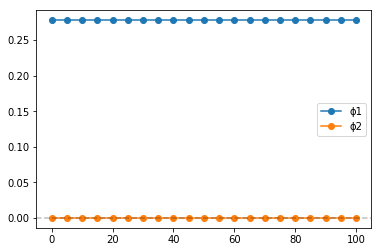

In [15]:
xs = np.linspace(0,1,mx)
times = np.linspace(0,tfinal,ntimes+1)
dx = xs[1]-xs[0]

result = np.vstack([frame.q for frame in claw.frames]).T
print(result.shape)

plt.plot(times,np.sum(result[:,0::2],axis=0)*dx,'o-')
plt.plot(times,np.sum(result[:,1::2],axis=0)*dx,'o-')
plt.axhline(y=0,color='black',linestyle='--',alpha=0.25)
plt.legend(['ϕ1','ϕ2'])
plt.show()

0.977065034968348

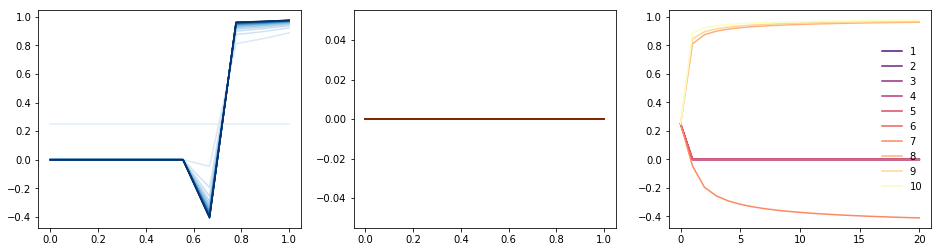

In [20]:
color1 = iter(plt.get_cmap('Blues')(np.linspace(0.1,1,ntimes)))
color2 = iter(plt.get_cmap('Oranges')(np.linspace(0.1,1,ntimes)))
tcol1  = iter(plt.get_cmap('magma')(np.linspace(0.25,1,mx)))

fig,ax = plt.subplots(ncols=3,figsize=(16,4))
for j,color in enumerate((color1,color2,tcol1)):
    if j<2:
        for i in range(ntimes):
            ax[j].plot(xs,result[:,j+2*i],color=next(color))
    else:
        pass
        for x in range(mx):
            ax[j].plot(np.arange(ntimes+1),result[x,0::2],color=next(color),label=str(x+1))
ax[2].legend(loc=0,frameon=False)
result[-1,-2:].sum()

2019-04-11 09:00:23,117 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



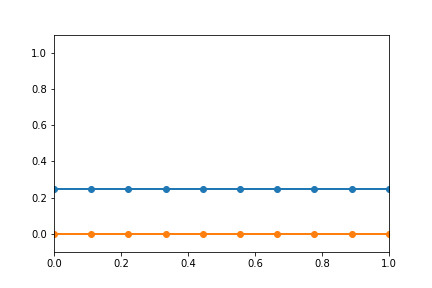
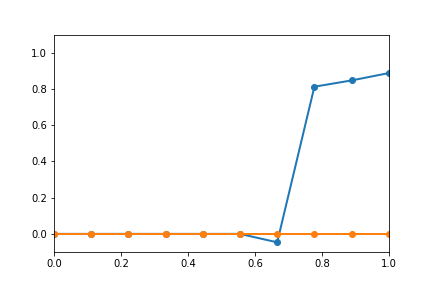
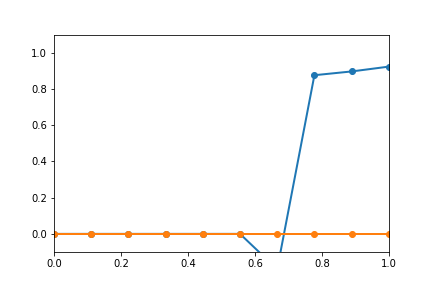
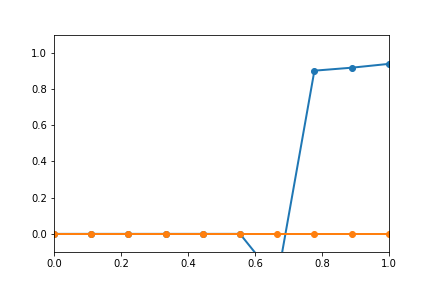
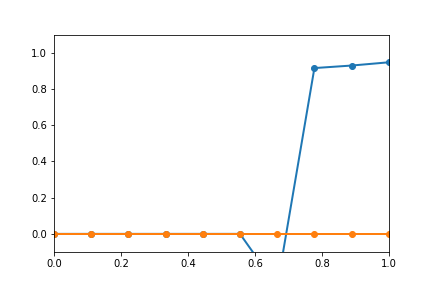
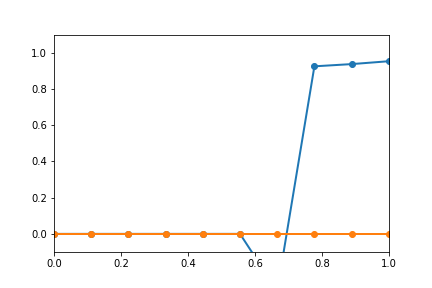
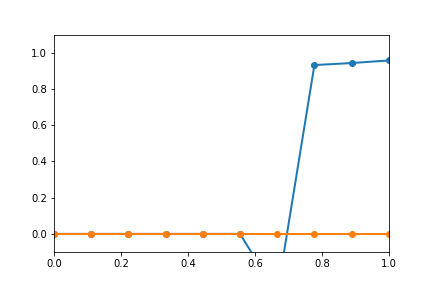
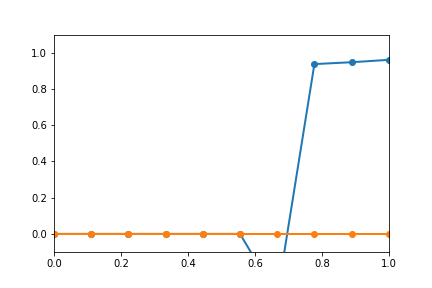
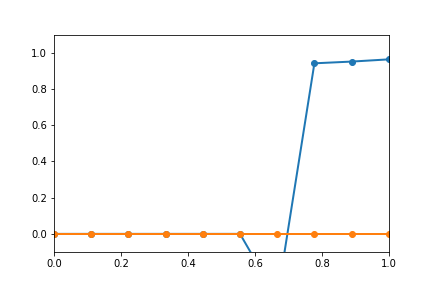
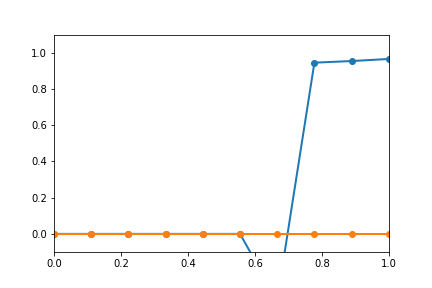
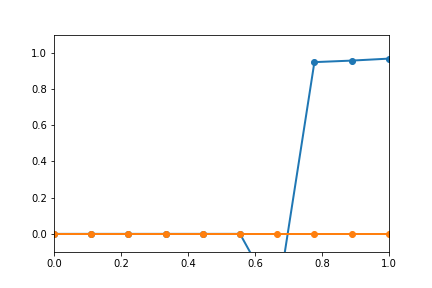
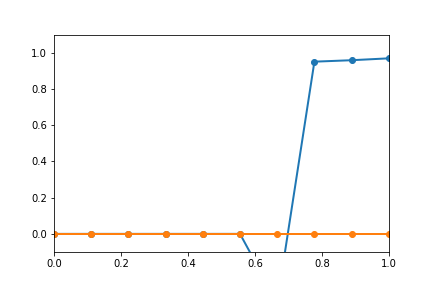
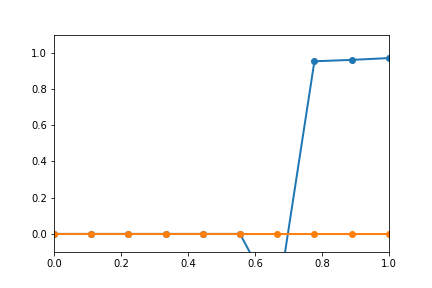
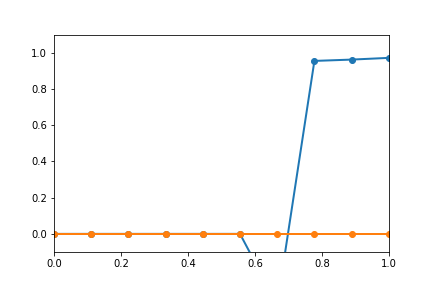
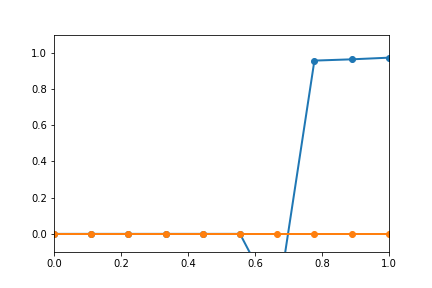
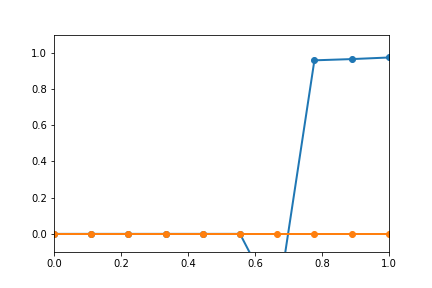
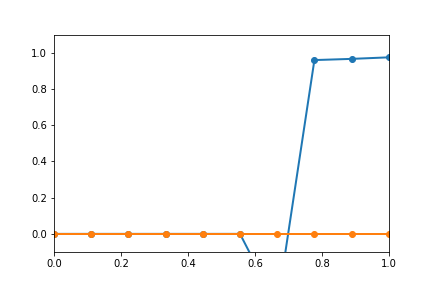
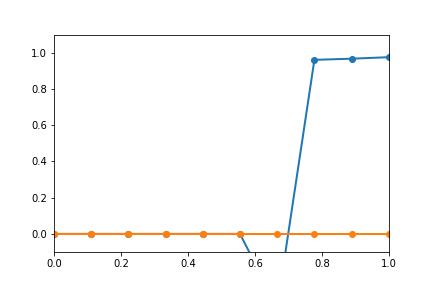
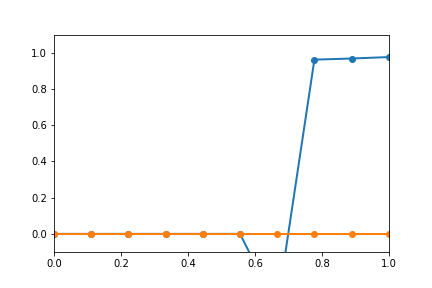
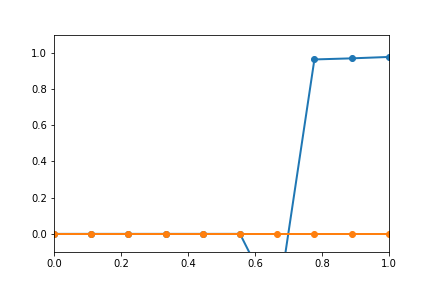
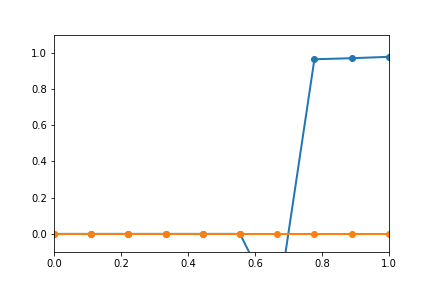

In [17]:
from matplotlib import animation
import matplotlib.pyplot as plt
from clawpack.visclaw.JSAnimation import IPython_display
import numpy as np

# x=domain.grid.x.centers
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.1, 1.1))

frame = claw.frames[0]
# species1 = frame.q[0,:]
line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)

def fplot(frame_number):
    frame = claw.frames[frame_number]
    species1 = frame.q[0,:]
    species2 = frame.q[1,:]
    line1.set_data(xs,species1)
    line2.set_data(xs,species2)
    return line1,line2

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=500)